# Learned World Model-based Reinforcement Learning

In [22]:
import numpy as np
import pandas as pd

In [ ]:
from module_lunar import LunarLander
from module_reward import reward_fn, reward_fn_torch
from module_simulate import simulate_with_policy
from module_policy import NNPolicy, heuristic_policy
from module_trainutil import update_results_list, update_rewards_over_time_list, crash_challenge_state_selector, state_selector, reward_over_time_plotting

In [2]:
from agm_te.dataset import DataSet
from agm_te.model import _train_agm, ApproxGenModel
from agm_te.estimate import init_agms_from_loaders

In [3]:
import torch; torch.set_printoptions(sci_mode=None)
import torch.optim as optim
import torch.nn.functional as F

# Check if CUDA is available
if torch.cuda.is_available():
    compute_device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    compute_device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


### Policy training methods

In [14]:
def pretrain_policy(policy:NNPolicy, pretraining_datadict, epochs=100, lr=0.00001):
    """
    Pretrain the policy using the pretraining data from the heuristic policy.
    """
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    weights = torch.tensor([1.0, 1.0, 1.0, 1.0], device=compute_device, dtype=torch.float32)

    for i in range(epochs):
        cumulative_loss = 0
        for j in range(len(pretraining_datadict['STATE'])):
            state = torch.tensor(pretraining_datadict['STATE'][j], device=compute_device, dtype=torch.float32)
            action = pretraining_datadict['INPUT'][j]
            action_argmax = torch.tensor(np.argmax(action, axis = -1), device=compute_device, dtype=torch.int64)

            action_logit = policy(state)
            loss = F.cross_entropy(action_logit, action_argmax, weight=weights)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            cumulative_loss += loss.item()

        print(f'Epoch {i+1}/{epochs}, Loss: {cumulative_loss}          ', end='\r')

    print()
    predicted = np.round(torch.nn.functional.softmax(action_logit, dim=-1).detach().cpu().numpy(), 1)[50:60]
    true = action[50:60]
    for i in range(10):
        print(f'Predicted: {predicted[i]}, True: {true[i]}')

In [15]:
def RL_train_policy(policy:NNPolicy, world_model:ApproxGenModel, start_states, horizon=5, gamma=0.99, lr=1e-6):
    """
    REINFORCE training of the policy.
    """
    optimizer = optim.SGD(policy.parameters(), lr=lr)
    
    for i, state_i in enumerate(start_states):
        state = torch.tensor(state_i, device=compute_device, dtype=torch.float32)
    
        log_probs = []
        rewards = []

        # Simulate an episode
        for t in range(horizon):
            # Get the action
            action_one_hot, log_prob = policy.act_train(state)

            # Get the next state
            stateaction = torch.cat([state, action_one_hot], dim=-1)
            next_state = world_model(stateaction)
            
            # Calculate the reward
            reward = reward_fn_torch(next_state[0], action_one_hot[0])  # Ensure reward_model accepts the right format

            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state

        # Calculate loss for the episode
        R = 0
        policy_loss = []
        for r, log_prob in zip(reversed(rewards), reversed(log_probs)):
            R = r + gamma * R
            policy_loss.append(-log_prob * R)

        policy_loss = torch.cat(policy_loss).sum()

        # Perform backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        print(f'Step {i + 1}/{len(start_states)}, Loss: {policy_loss.item()}              ', end='\r')

    print()


## Replicate runs of Appendix Algorithm 1


 -------------- Replicate 1/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

Heuristic (rep. 0)
Final Reward: 500.99(+-79.01), C: 0.1% L: 98.4%, Lt: 171.59(+-9.94), Fuel: 24.66(+-1.12)

Epoch 10/10, Loss: 43.01646169088781          
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [1. 0. 0. 0.], True: [1. 0. 0. 0.]
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [0. 0. 1. 0.], True: [0. 0. 1. 0.]
Predicted: [0.2 0.5 0.3 0. ], True: [0. 0. 1. 0.]
> Pre-trained the policy model to imitate the heuristic controller.
Replicate simulation 200/200

Pretrained (rep. 0)
Final Reward: 504.71(+-71.36), C: 0.0% L: 99.5%, Lt: 171.25(+-9.12), Fuel: 24.69(+-

/home/dan/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dan/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dan/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dan/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/dan/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


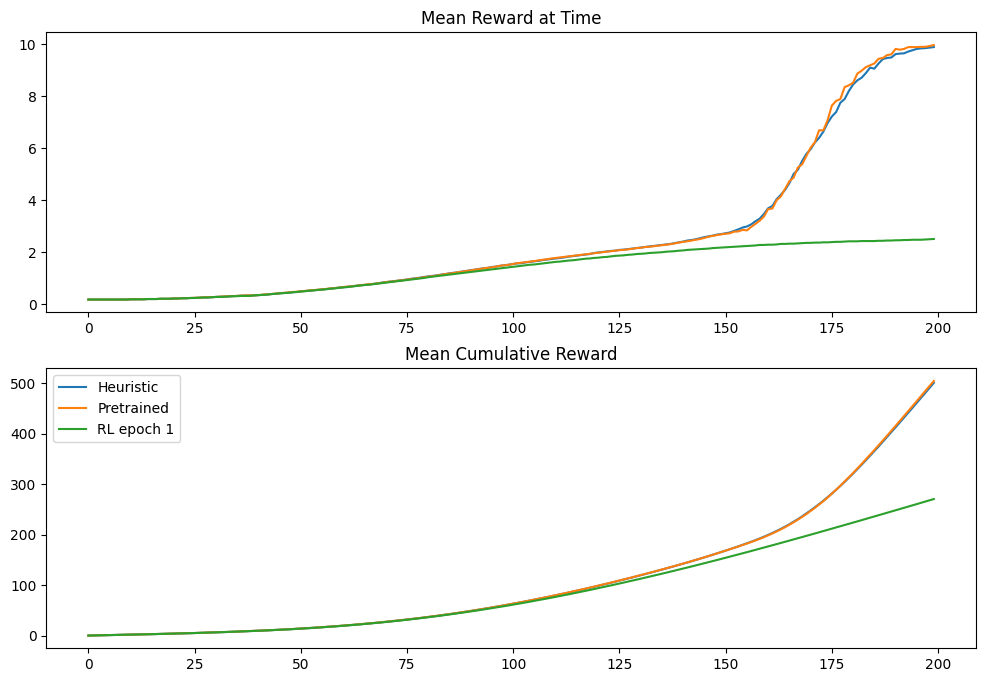


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.681e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.034e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 153.01022338867188                  
Replicate simulation 200/200

RL epoch 2 (rep. 0)
Final Reward: 260.35(+-11.35), C: 0.0% L: 0.0%, Lt: nan(+-nan), Fuel: 34.45(+-1.06)



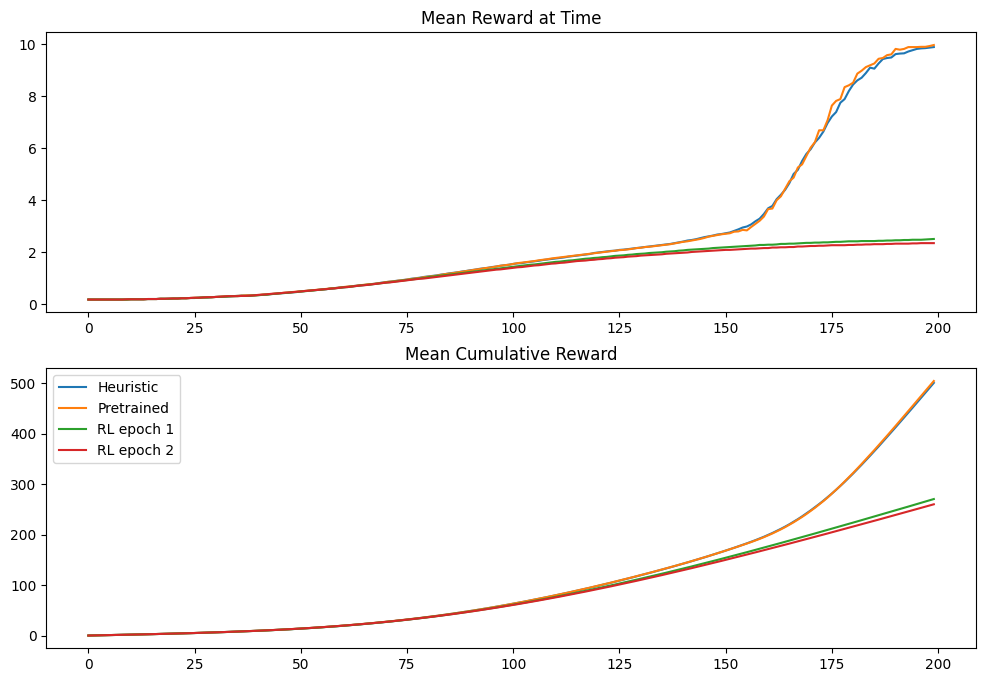


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.633e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.819e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 13.219016075134277                  
Replicate simulation 200/200

RL epoch 3 (rep. 0)
Final Reward: 264.64(+-13.07), C: 0.0% L: 0.0%, Lt: nan(+-nan), Fuel: 34.52(+-0.97)



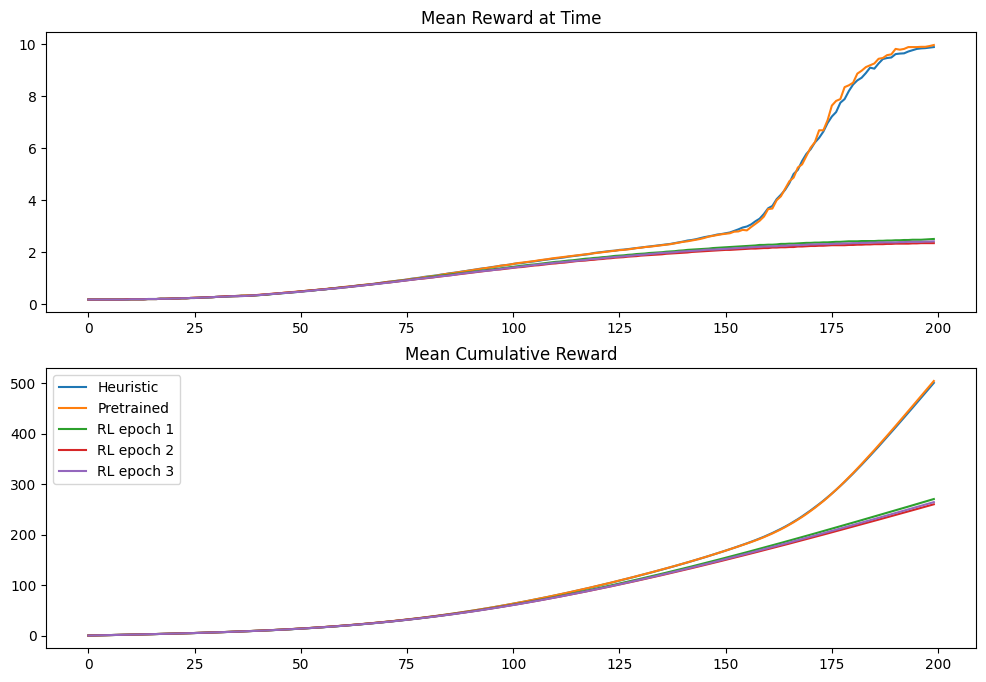


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.632e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.619e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 8.6612548828125                     
Replicate simulation 200/200

RL epoch 4 (rep. 0)
Final Reward: 532.73(+-83.96), C: 0.5% L: 97.5%, Lt: 167.11(+-10.05), Fuel: 24.06(+-1.14)



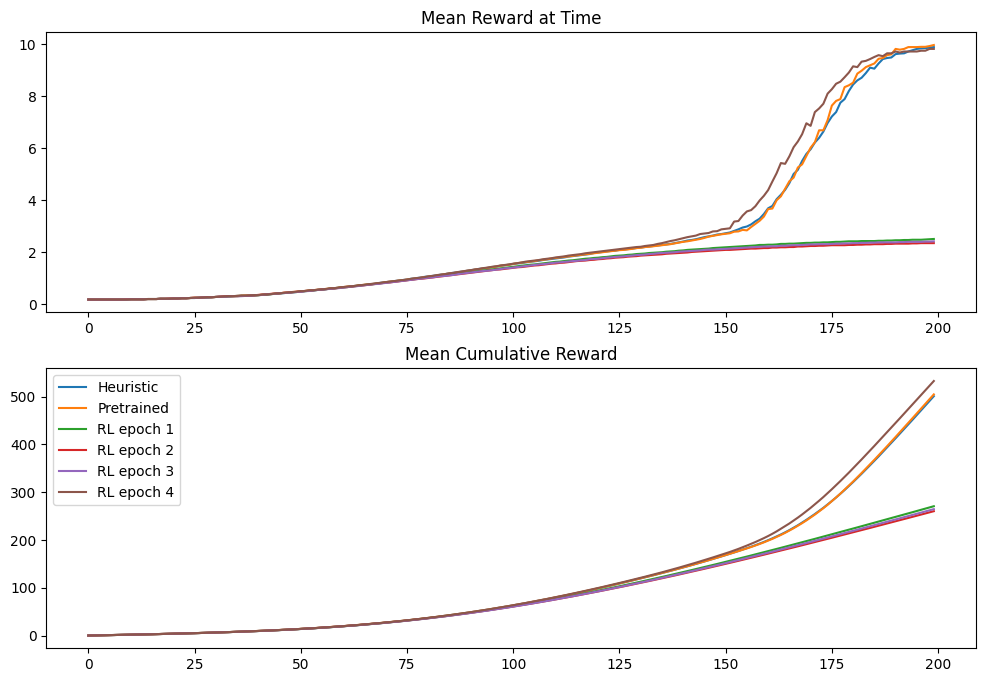


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.737e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.526e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 41.965980529785156                  
Replicate simulation 200/200

RL epoch 5 (rep. 0)
Final Reward: 574.35(+-90.85), C: 0.5% L: 95.5%, Lt: 161.32(+-9.73), Fuel: 22.63(+-1.02)



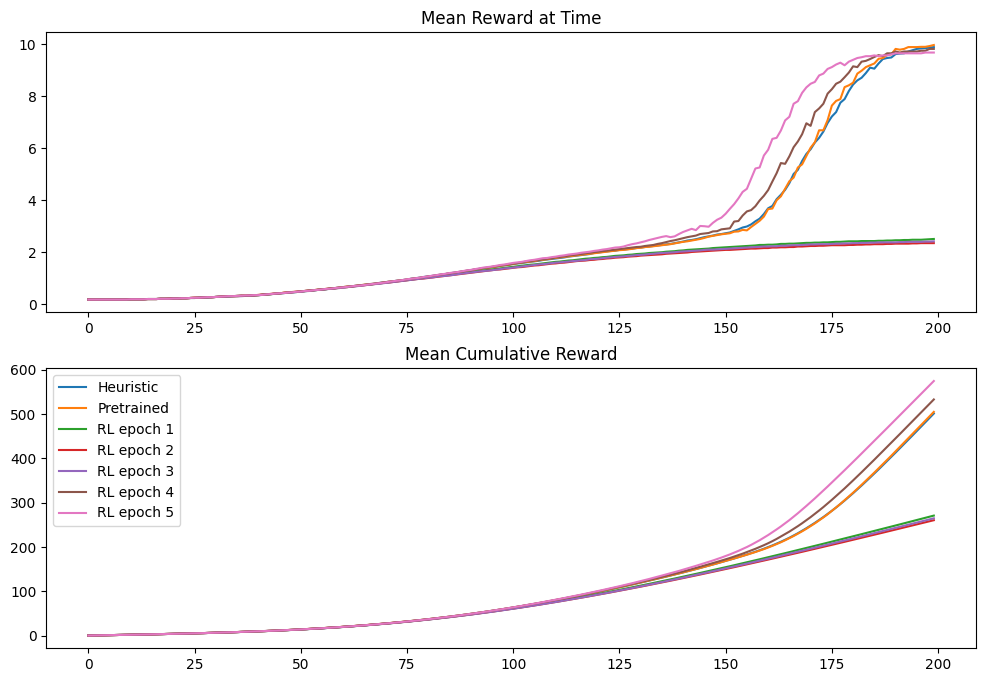

> Training complete for replicate 0. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      0   Heuristic    500.99      0.1    98.4             171.59   
1      0  Pretrained    504.71      0.0    99.5             171.25   
2      0  RL epoch 1    270.76      0.0     0.0                NaN   
3      0  RL epoch 2    260.35      0.0     0.0                NaN   
4      0  RL epoch 3    264.64      0.0     0.0                NaN   
5      0  RL epoch 4    532.73      0.5    97.5             167.11   
6      0  RL epoch 5    574.35      0.5    95.5             161.32   

   mean_fuel_consumption  
0                  24.66  
1                  24.69  
2                  34.38  
3                  34.45  
4                  34.52  
5                  24.06  
6                  22.63  

 -------------- Replicate 2/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

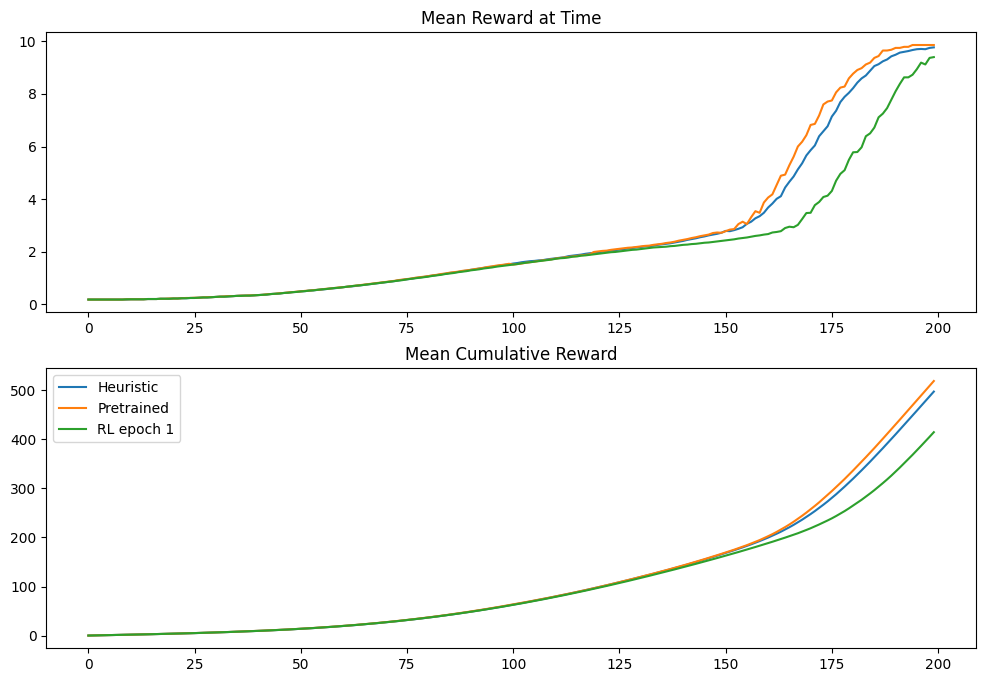


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.566e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.019e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 0.00014265385107137263              
Replicate simulation 200/200

RL epoch 2 (rep. 1)
Final Reward: 506.2(+-79.25), C: 0.0% L: 97.5%, Lt: 170.63(+-9.6), Fuel: 24.69(+-0.99)



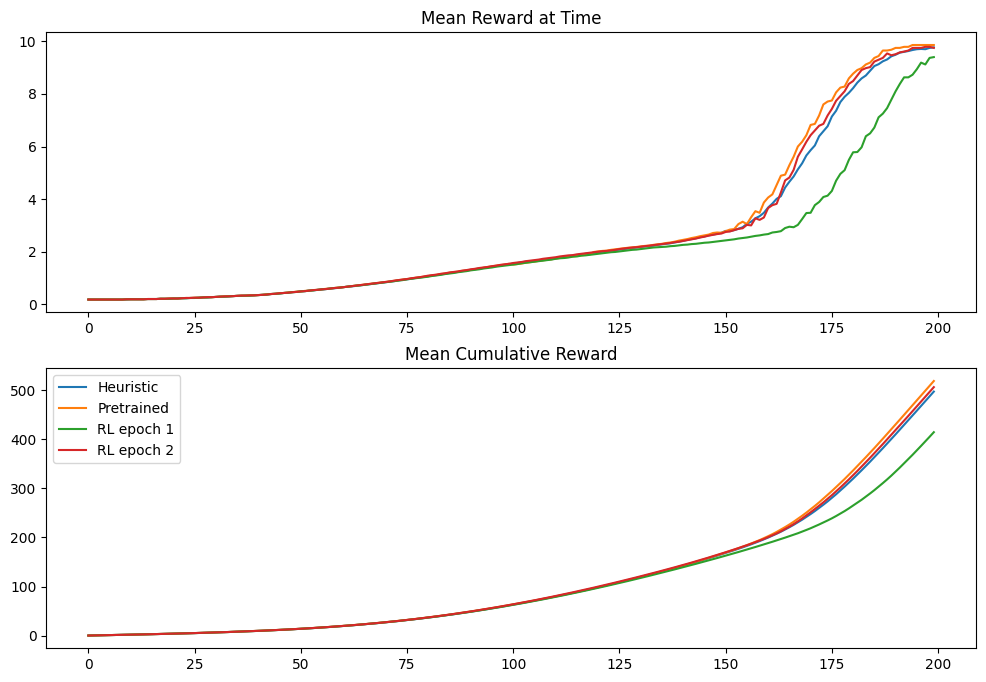


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.576e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.87e-055
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 96.92241668701172                   
Replicate simulation 200/200

RL epoch 3 (rep. 1)
Final Reward: 579.3(+-92.44), C: 0.0% L: 95.5%, Lt: 160.77(+-9.95), Fuel: 22.26(+-1.04)



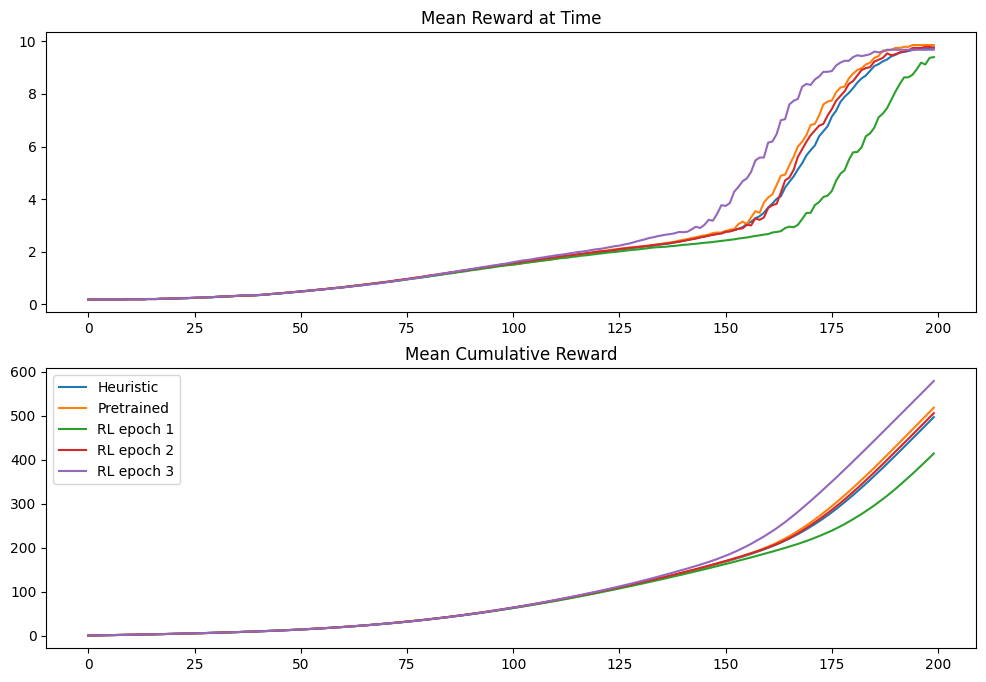


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.966e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.924e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 10.748814582824707                  
Replicate simulation 200/200

RL epoch 4 (rep. 1)
Final Reward: 494.89(+-80.36), C: 0.0% L: 96.5%, Lt: 171.75(+-9.19), Fuel: 25.24(+-1.12)



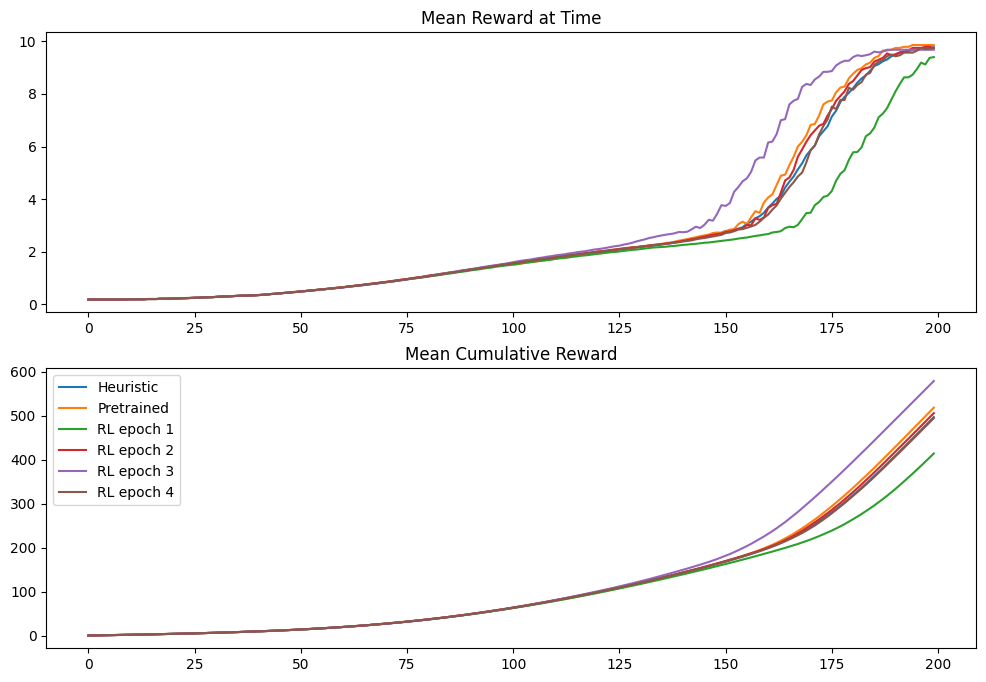


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.879e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.768e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 0.0029871398583054543               
Replicate simulation 200/200

RL epoch 5 (rep. 1)
Final Reward: 391.35(+-70.5), C: 0.0% L: 87.0%, Lt: 183.66(+-7.81), Fuel: 27.57(+-1.36)



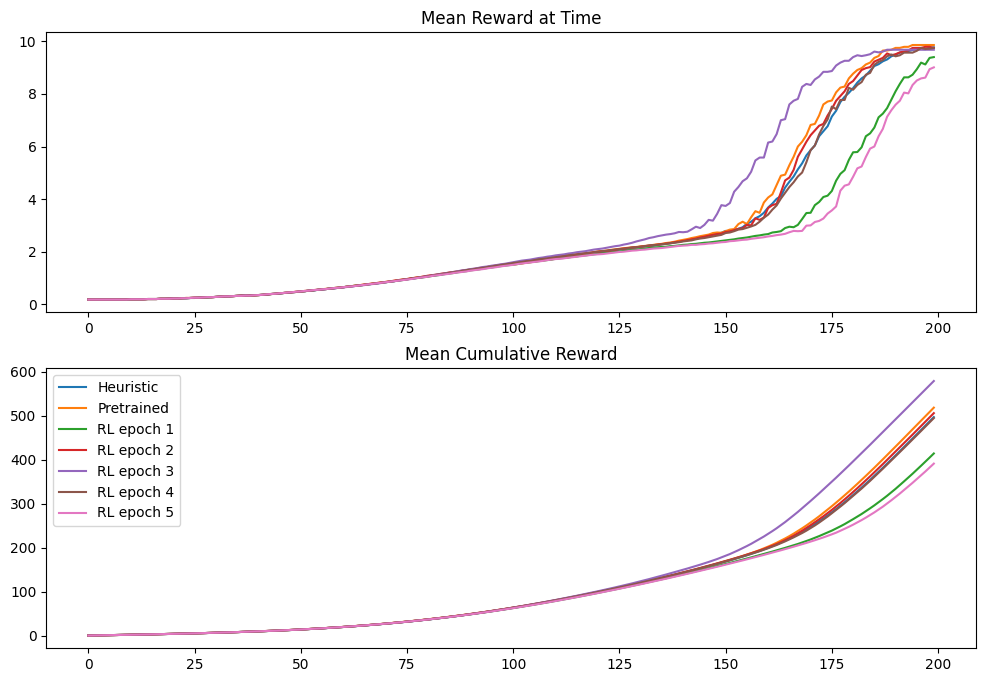

> Training complete for replicate 1. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      1   Heuristic    497.16      0.2    96.6             171.62   
1      1  Pretrained    518.70      0.5    97.5             168.93   
2      1  RL epoch 1    414.43      0.0    92.0             181.38   
3      1  RL epoch 2    506.20      0.0    97.5             170.63   
4      1  RL epoch 3    579.30      0.0    95.5             160.77   
5      1  RL epoch 4    494.89      0.0    96.5             171.75   
6      1  RL epoch 5    391.35      0.0    87.0             183.66   

   mean_fuel_consumption  
0                  24.62  
1                  24.37  
2                  26.85  
3                  24.69  
4                  22.26  
5                  25.24  
6                  27.57  

 -------------- Replicate 3/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

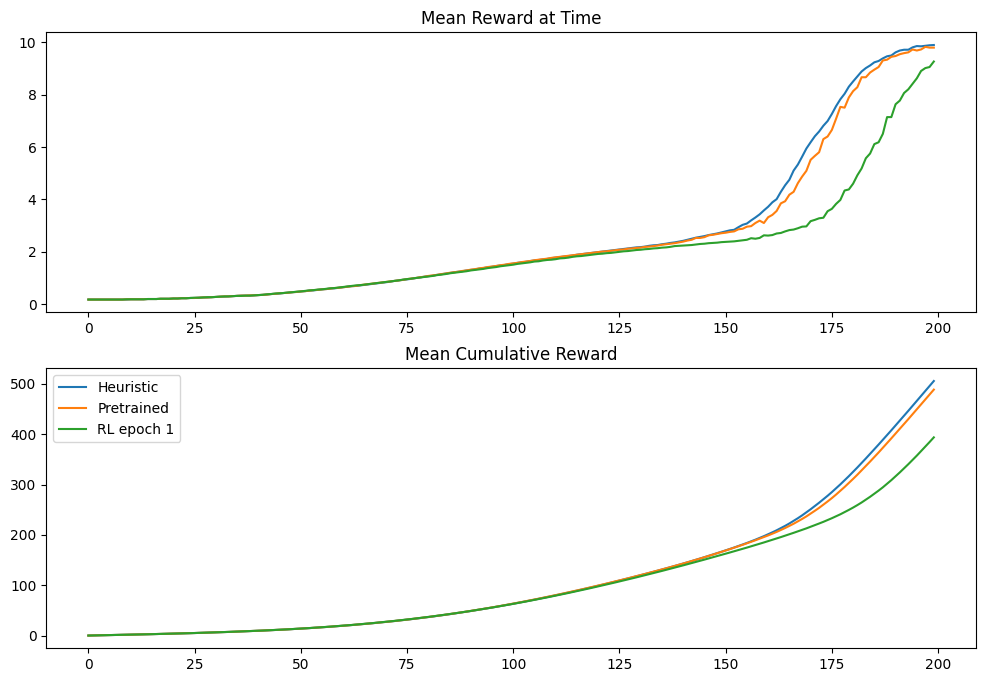


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.102e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.736e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 28.333572387695312                  
Replicate simulation 200/200

RL epoch 2 (rep. 2)
Final Reward: 332.11(+-57.7), C: 0.0% L: 61.0%, Lt: 189.06(+-6.74), Fuel: 29.92(+-1.69)



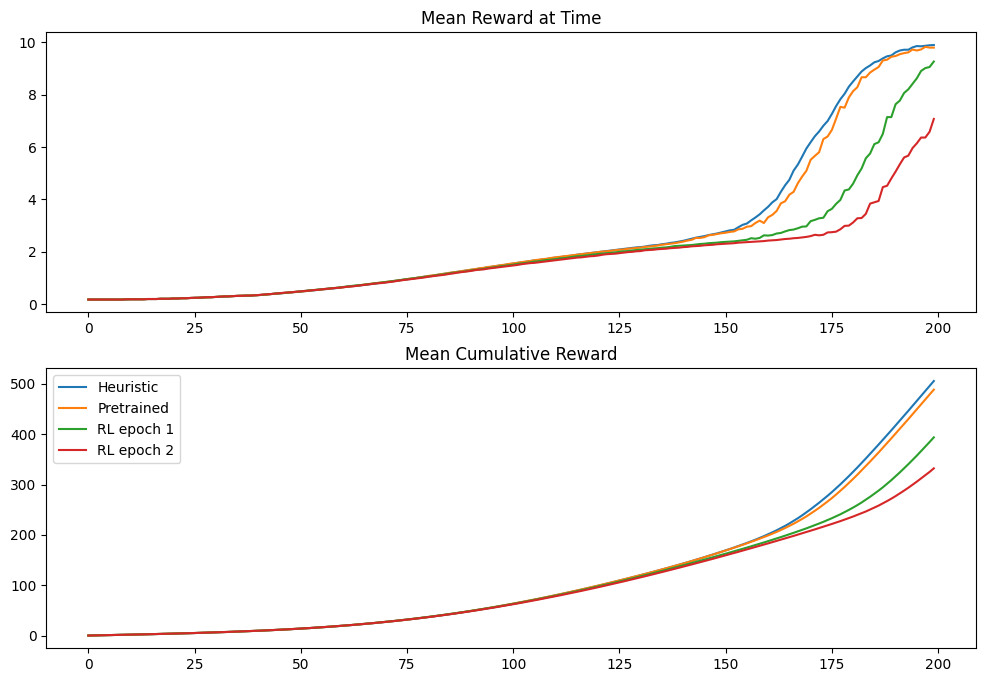


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.1e-0505
> Trained the world model on the new data
Epoch [90/100], Loss: 4.617e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 28.351665496826172                  
Replicate simulation 200/200

RL epoch 3 (rep. 2)
Final Reward: 420.81(+-76.8), C: 0.0% L: 93.5%, Lt: 180.63(+-9.28), Fuel: 27.0(+-1.41)



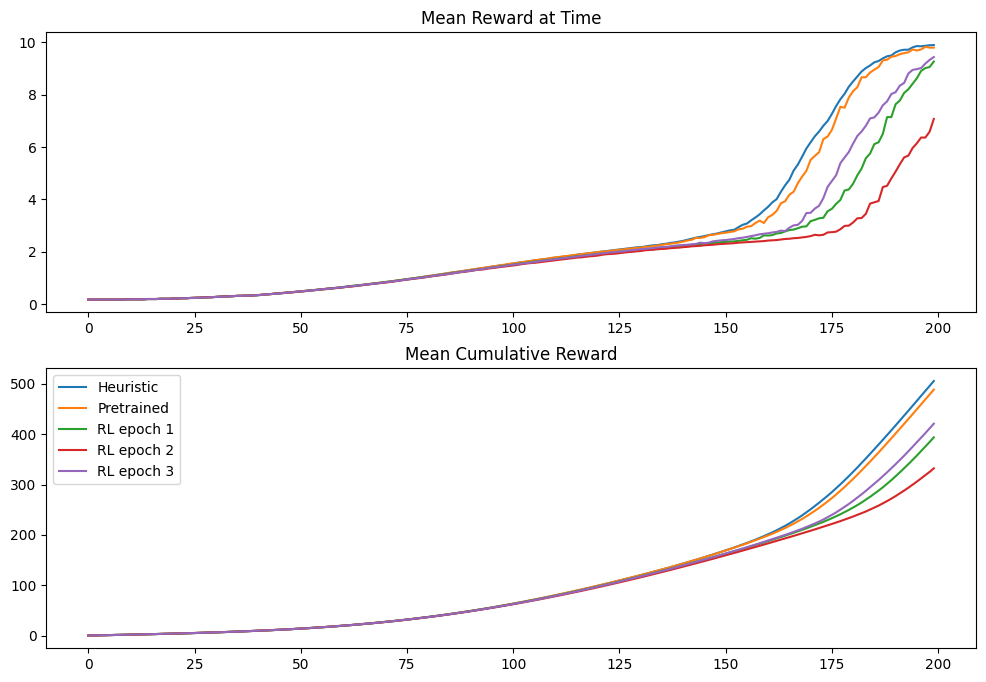


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.998e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.519e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 247.6031951904297                   
Replicate simulation 200/200

RL epoch 4 (rep. 2)
Final Reward: 555.55(+-81.02), C: 0.0% L: 98.0%, Lt: 164.62(+-9.61), Fuel: 23.37(+-0.96)



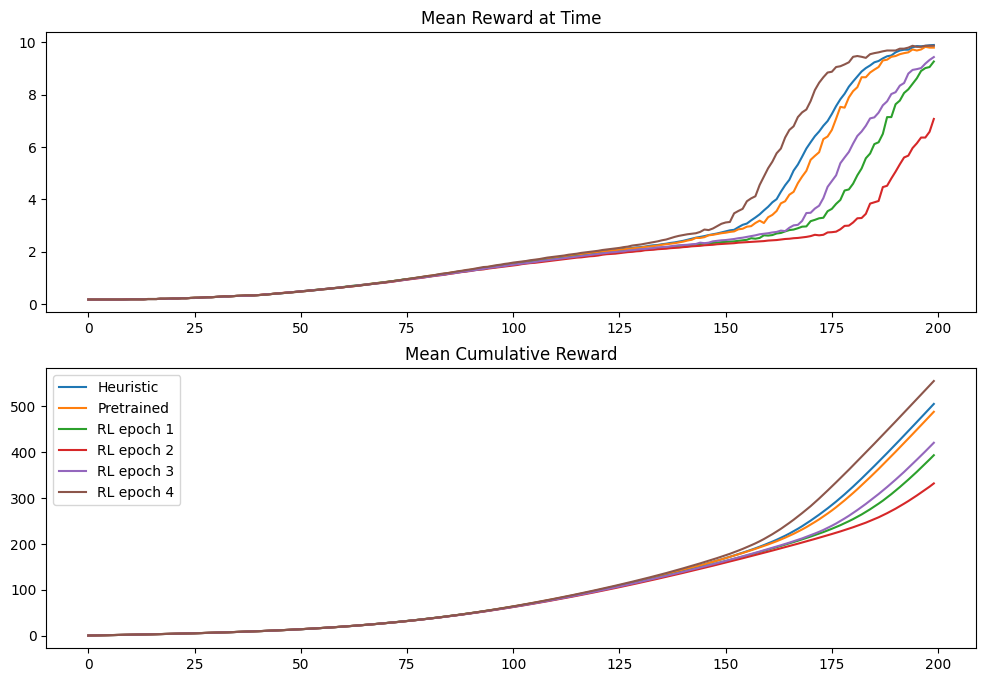


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.923e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.473e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 4.315126895904541                   
Replicate simulation 200/200

RL epoch 5 (rep. 2)
Final Reward: 493.0(+-78.98), C: 0.0% L: 97.0%, Lt: 172.06(+-9.62), Fuel: 24.94(+-0.9)



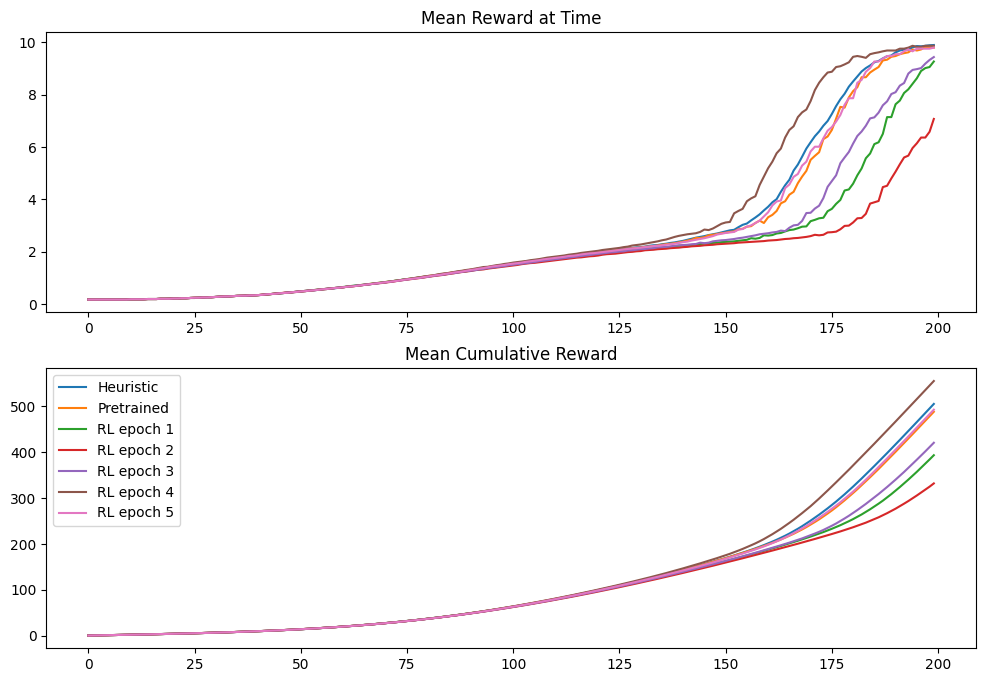

> Training complete for replicate 2. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      2   Heuristic    505.54      0.0    98.5             171.01   
1      2  Pretrained    488.43      0.0    97.5             173.14   
2      2  RL epoch 1    393.64      0.0    90.0             183.83   
3      2  RL epoch 2    332.11      0.0    61.0             189.06   
4      2  RL epoch 3    420.81      0.0    93.5             180.63   
5      2  RL epoch 4    555.55      0.0    98.0             164.62   
6      2  RL epoch 5    493.00      0.0    97.0             172.06   

   mean_fuel_consumption  
0                  24.60  
1                  24.74  
2                  27.64  
3                  29.92  
4                  27.00  
5                  23.37  
6                  24.94  

 -------------- Replicate 4/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

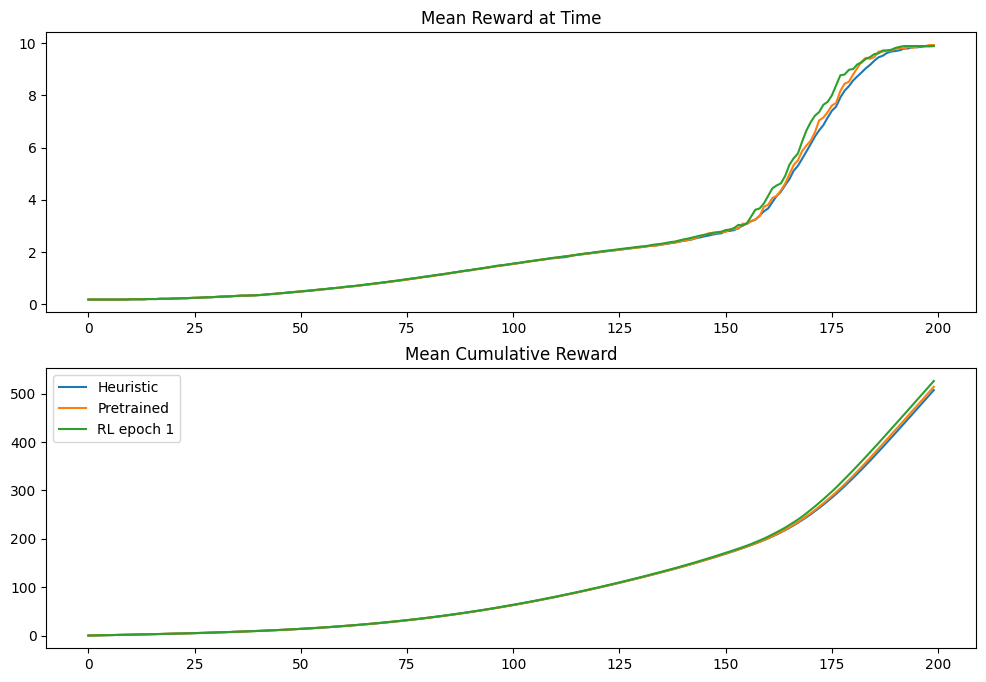


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.637e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.152e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 16.3125                             
Replicate simulation 200/200

RL epoch 2 (rep. 3)
Final Reward: 504.26(+-77.74), C: 0.5% L: 97.0%, Lt: 170.65(+-9.19), Fuel: 24.65(+-1.19)



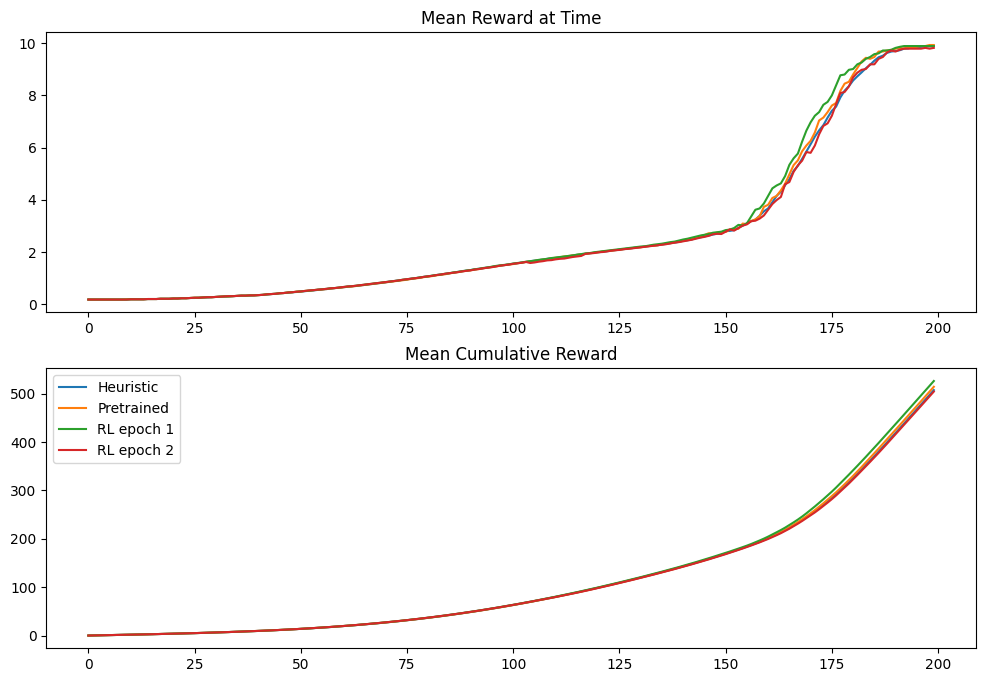


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.364e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.901e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 30.33806800842285                   
Replicate simulation 200/200

RL epoch 3 (rep. 3)
Final Reward: 331.15(+-56.8), C: 0.0% L: 65.5%, Lt: 189.35(+-6.63), Fuel: 29.42(+-1.88)



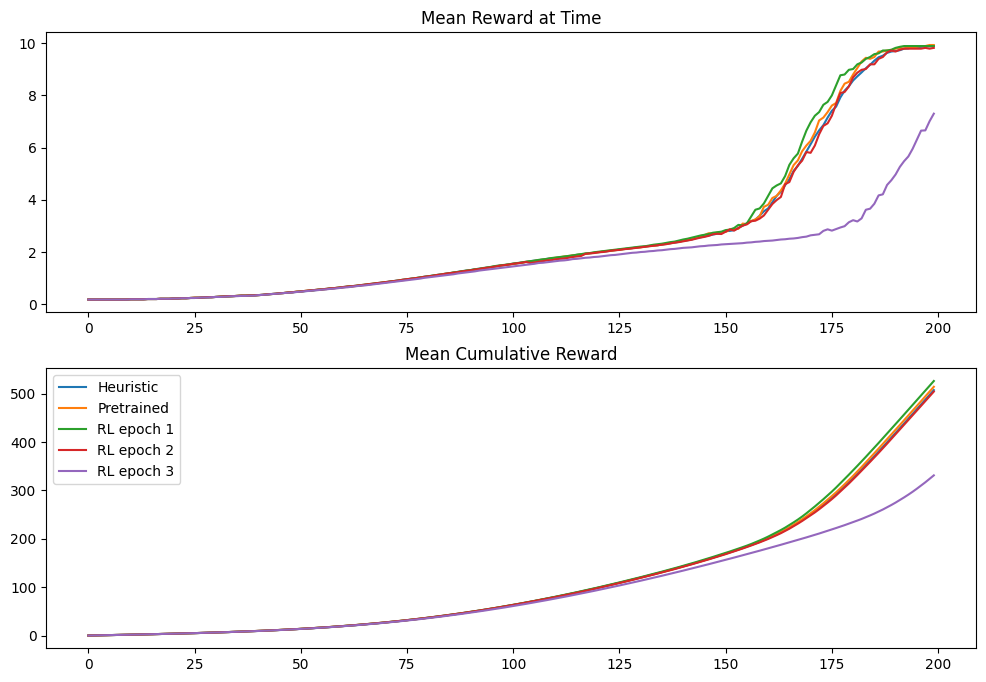


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.167e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.758e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 97.79190826416016                   
Replicate simulation 200/200

RL epoch 4 (rep. 3)
Final Reward: 284.89(+-24.05), C: 0.0% L: 18.0%, Lt: 194.42(+-4.04), Fuel: 32.1(+-1.83)



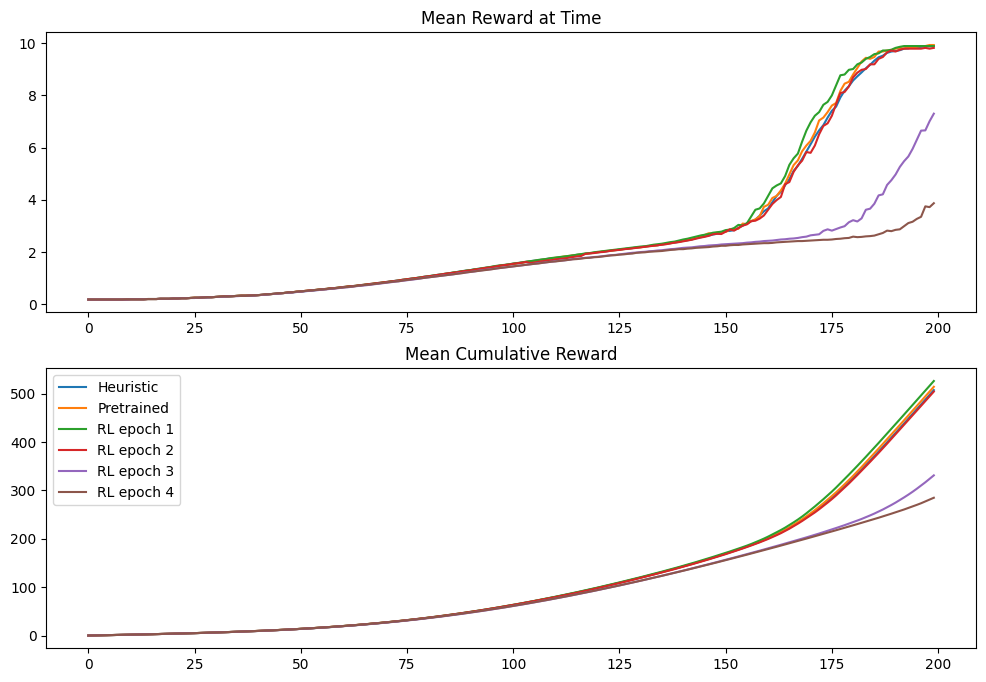


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.893e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.651e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 81.94477844238281                   
Replicate simulation 200/200

RL epoch 5 (rep. 3)
Final Reward: 331.65(+-57.41), C: 0.0% L: 62.0%, Lt: 188.83(+-6.67), Fuel: 29.63(+-1.96)



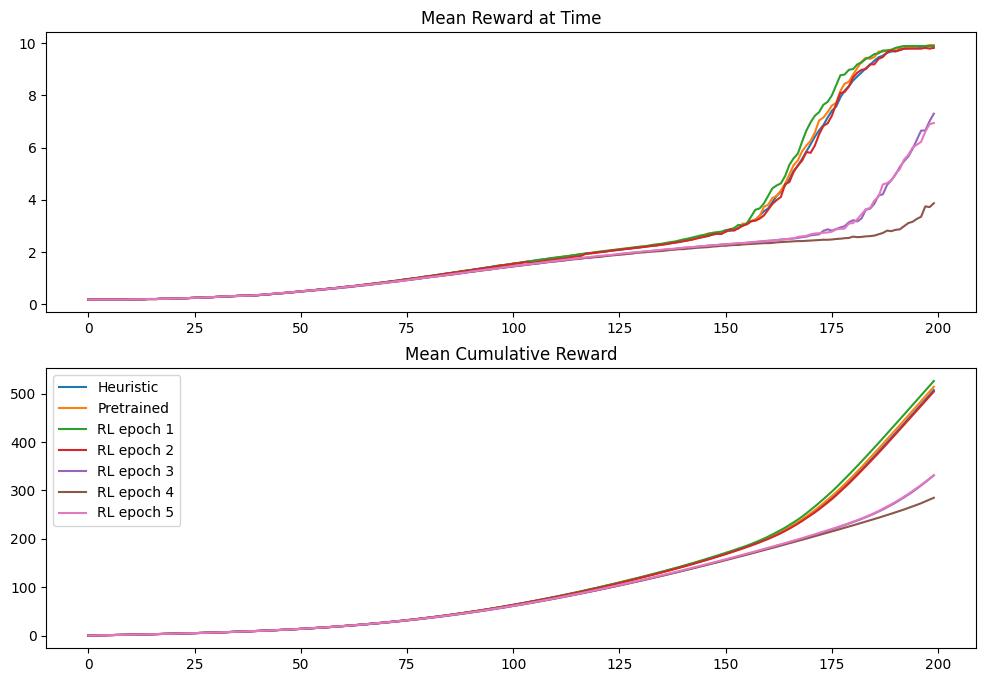

> Training complete for replicate 3. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      3   Heuristic    507.34      0.2    98.3             170.69   
1      3  Pretrained    514.18      0.0    99.0             169.96   
2      3  RL epoch 1    526.11      0.0    98.5             168.42   
3      3  RL epoch 2    504.26      0.5    97.0             170.65   
4      3  RL epoch 3    331.15      0.0    65.5             189.35   
5      3  RL epoch 4    284.89      0.0    18.0             194.42   
6      3  RL epoch 5    331.65      0.0    62.0             188.83   

   mean_fuel_consumption  
0                  24.58  
1                  24.56  
2                  24.29  
3                  24.65  
4                  29.42  
5                  32.10  
6                  29.63  

 -------------- Replicate 5/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

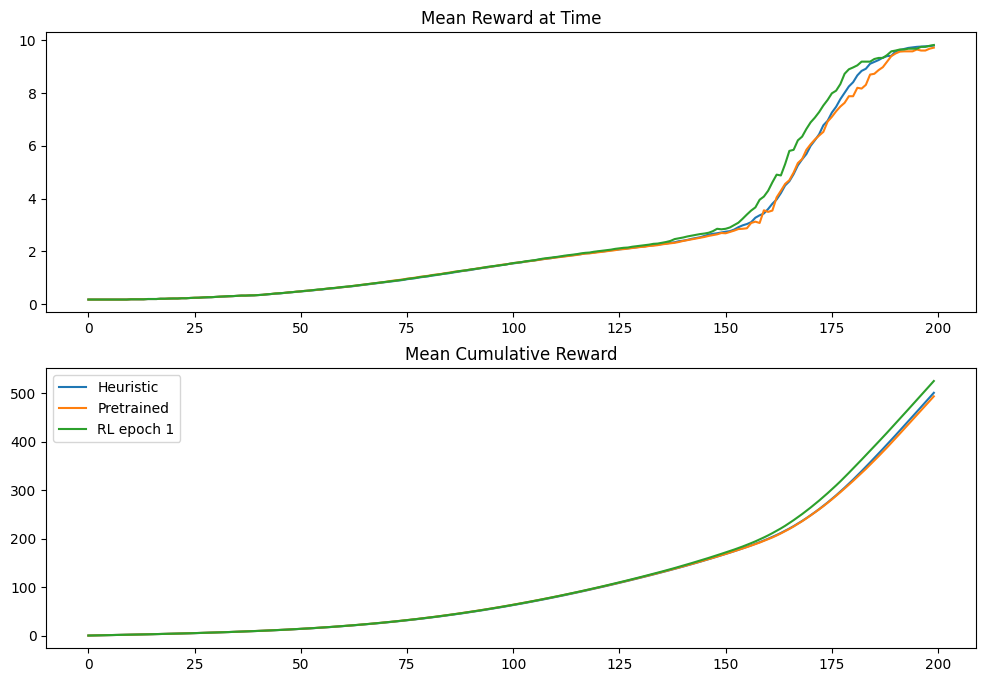


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.925e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.262e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 9.482637405395508                   
Replicate simulation 200/200

RL epoch 2 (rep. 4)
Final Reward: 524.11(+-97.63), C: 0.0% L: 93.0%, Lt: 166.92(+-10.58), Fuel: 23.62(+-1.47)



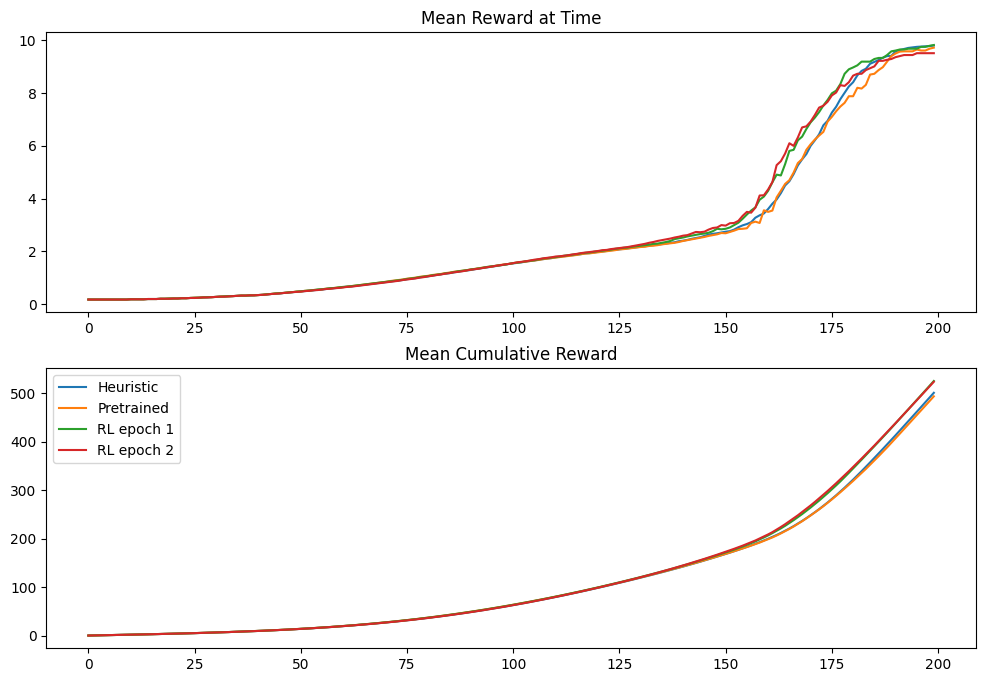


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.933e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.95e-055
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 24.16573715209961                   
Replicate simulation 200/200

RL epoch 3 (rep. 4)
Final Reward: 539.6(+-94.6), C: 0.0% L: 92.5%, Lt: 165.02(+-9.2), Fuel: 23.02(+-1.23)



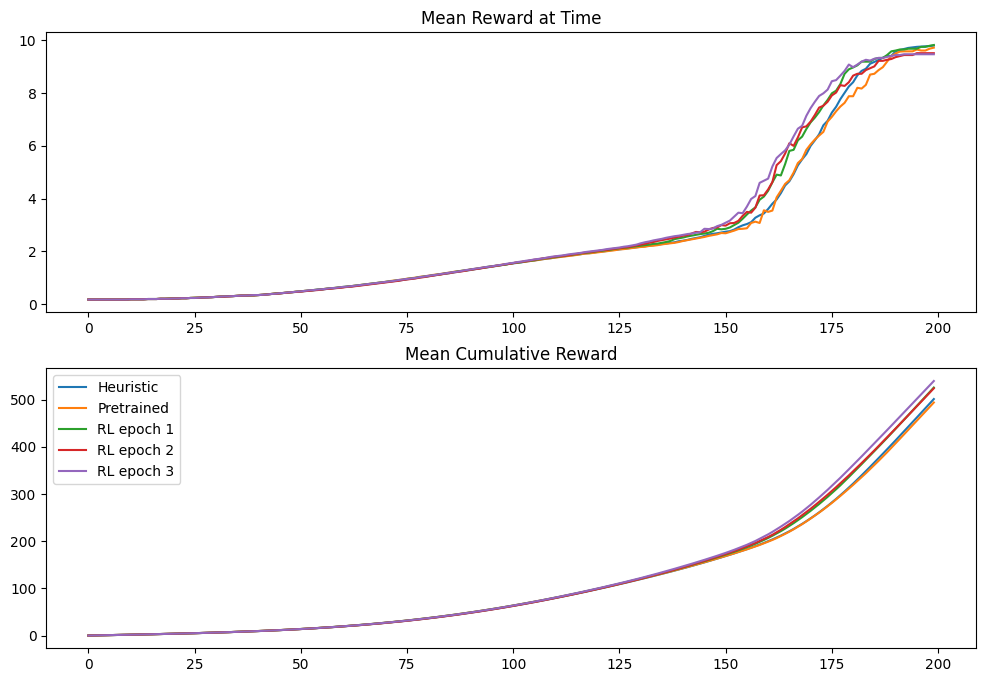


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.952e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.904e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 0.0001420050102751702               
Replicate simulation 200/200

RL epoch 4 (rep. 4)
Final Reward: 572.74(+-101.15), C: 0.5% L: 93.5%, Lt: 161.31(+-10.73), Fuel: 21.7(+-1.22)



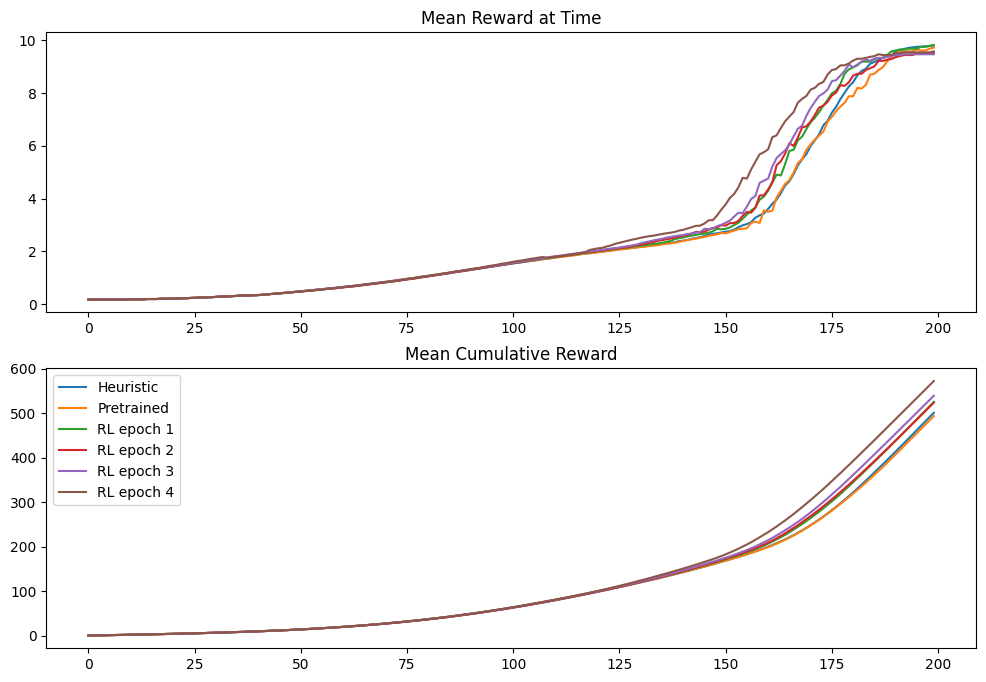


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.614e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.897e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 222.13670349121094                  
Replicate simulation 200/200

RL epoch 5 (rep. 4)
Final Reward: 594.41(+-126.12), C: 2.5% L: 89.0%, Lt: 158.05(+-12.96), Fuel: 19.62(+-1.01)



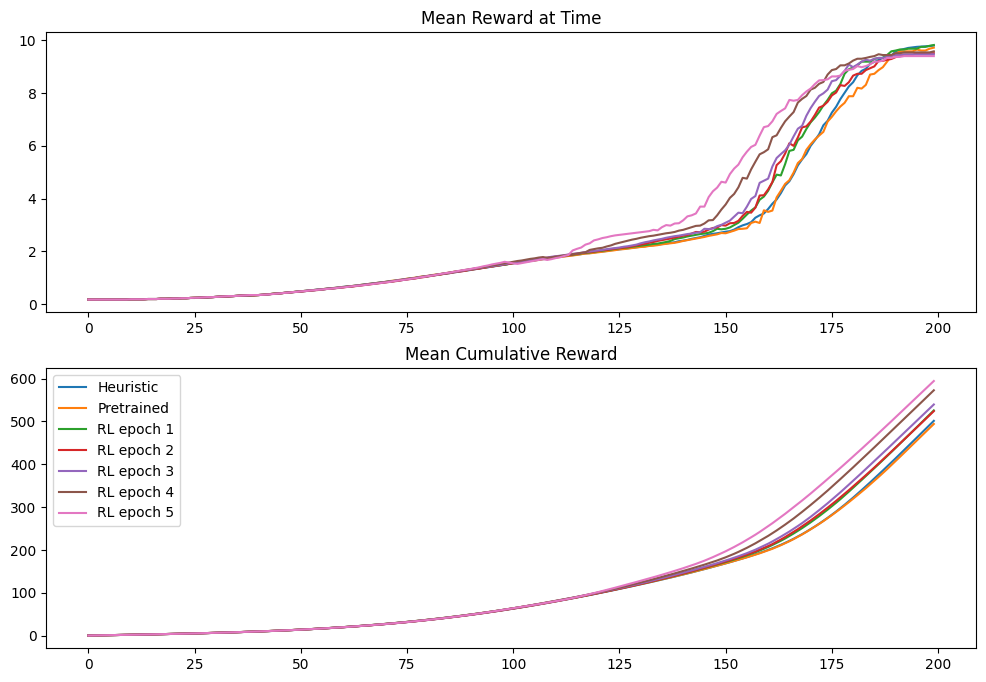

> Training complete for replicate 4. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      4   Heuristic    501.39      0.0    97.1             171.11   
1      4  Pretrained    494.09      0.0    96.0             171.96   
2      4  RL epoch 1    525.75      0.0    97.5             168.10   
3      4  RL epoch 2    524.11      0.0    93.0             166.92   
4      4  RL epoch 3    539.60      0.0    92.5             165.02   
5      4  RL epoch 4    572.74      0.5    93.5             161.31   
6      4  RL epoch 5    594.41      2.5    89.0             158.05   

   mean_fuel_consumption  
0                  24.67  
1                  24.71  
2                  24.18  
3                  23.62  
4                  23.02  
5                  21.70  
6                  19.62  

 -------------- Replicate 6/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

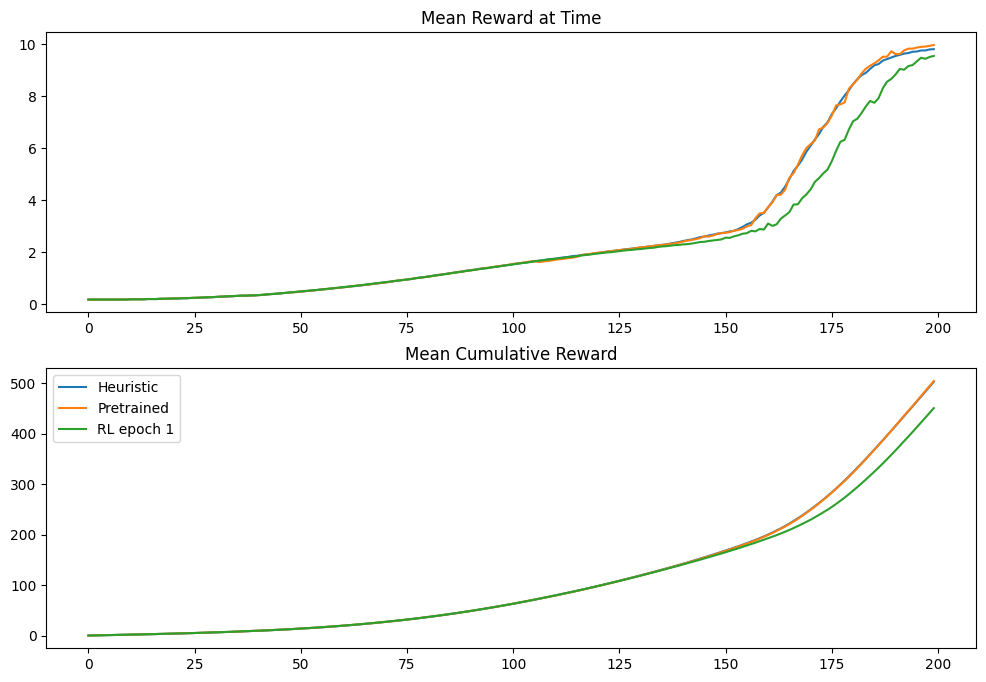


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.027e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.57e-055
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 4.479972994886339e-05               
Replicate simulation 200/200

RL epoch 2 (rep. 5)
Final Reward: 473.03(+-83.97), C: 0.5% L: 95.5%, Lt: 174.57(+-10.14), Fuel: 25.31(+-1.25)



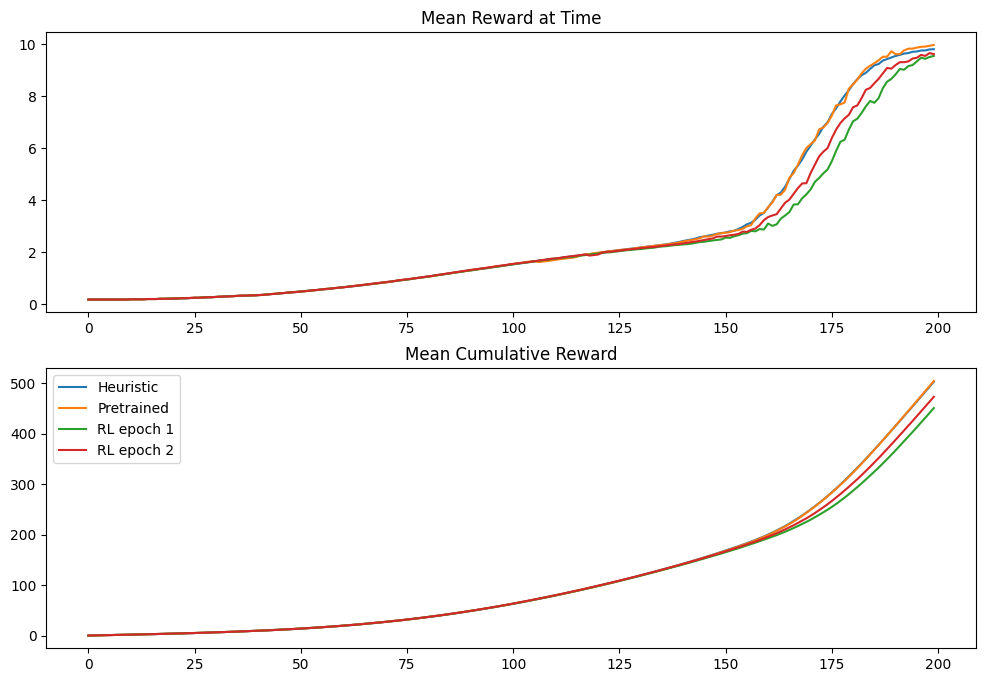


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.795e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.463e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 73.67607879638672                   
Replicate simulation 200/200

RL epoch 3 (rep. 5)
Final Reward: 562.24(+-73.93), C: 0.0% L: 99.5%, Lt: 164.09(+-9.53), Fuel: 23.14(+-1.07)



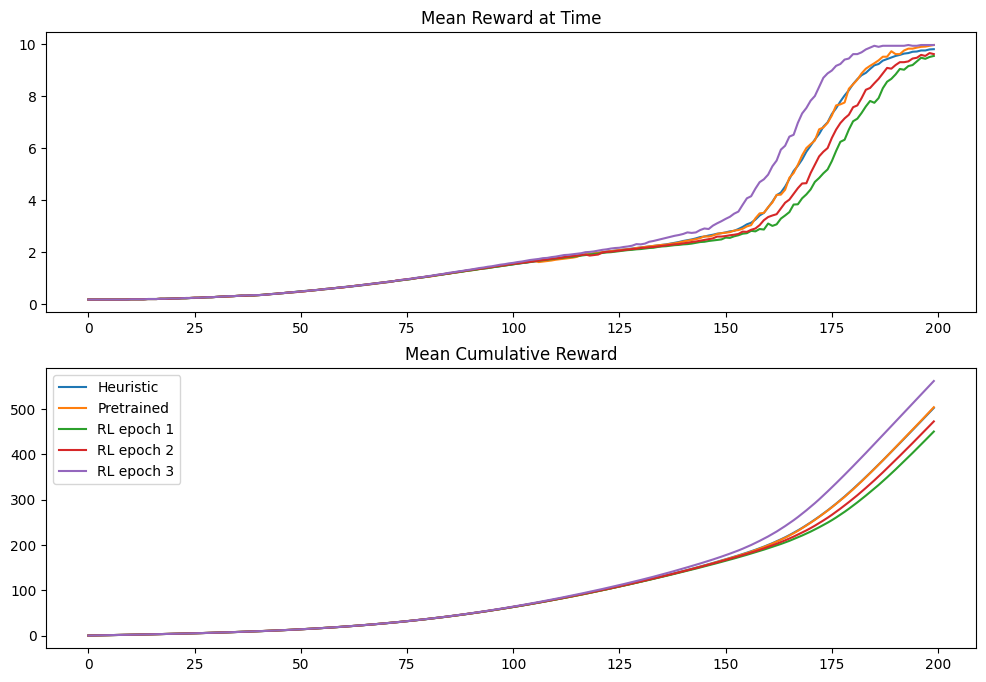


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.053e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.443e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 0.00014319090405479074              
Replicate simulation 200/200

RL epoch 4 (rep. 5)
Final Reward: 593.15(+-85.36), C: 0.5% L: 97.0%, Lt: 159.52(+-9.85), Fuel: 21.85(+-0.86)



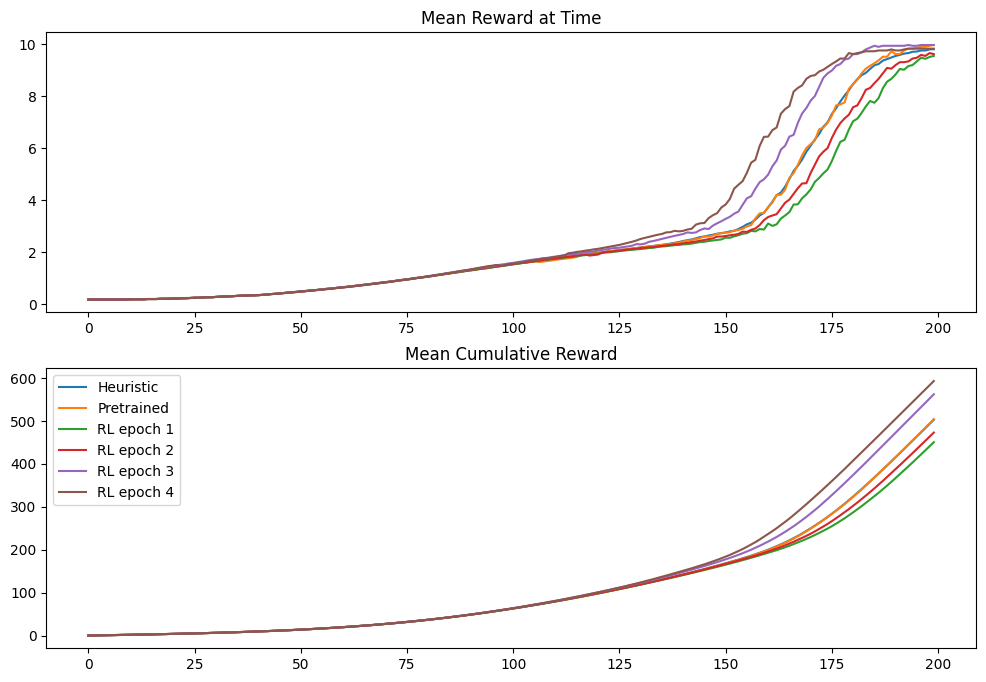


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.366e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.512e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 0.03130708262324333                 
Replicate simulation 200/200

RL epoch 5 (rep. 5)
Final Reward: 619.83(+-99.47), C: 1.0% L: 95.0%, Lt: 155.88(+-10.28), Fuel: 20.68(+-0.83)



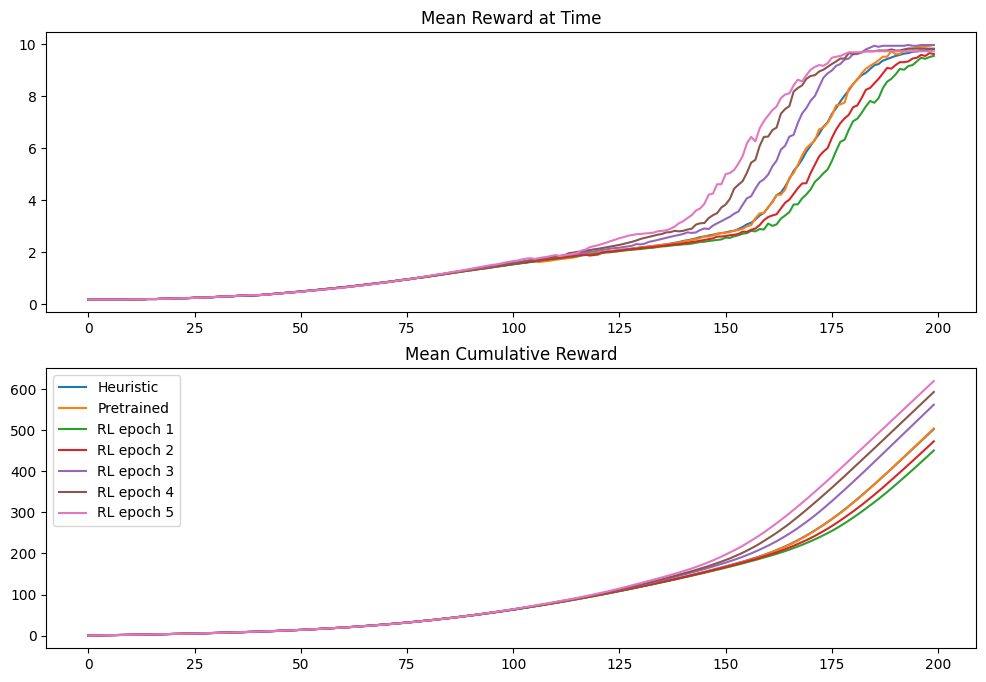

> Training complete for replicate 5. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      5   Heuristic    502.80      0.2    97.1             170.87   
1      5  Pretrained    504.33      0.5    99.0             171.25   
2      5  RL epoch 1    450.67      0.0    93.5             176.83   
3      5  RL epoch 2    473.03      0.5    95.5             174.57   
4      5  RL epoch 3    562.24      0.0    99.5             164.09   
5      5  RL epoch 4    593.15      0.5    97.0             159.52   
6      5  RL epoch 5    619.83      1.0    95.0             155.88   

   mean_fuel_consumption  
0                  24.59  
1                  24.65  
2                  26.17  
3                  25.31  
4                  23.14  
5                  21.85  
6                  20.68  

 -------------- Replicate 7/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

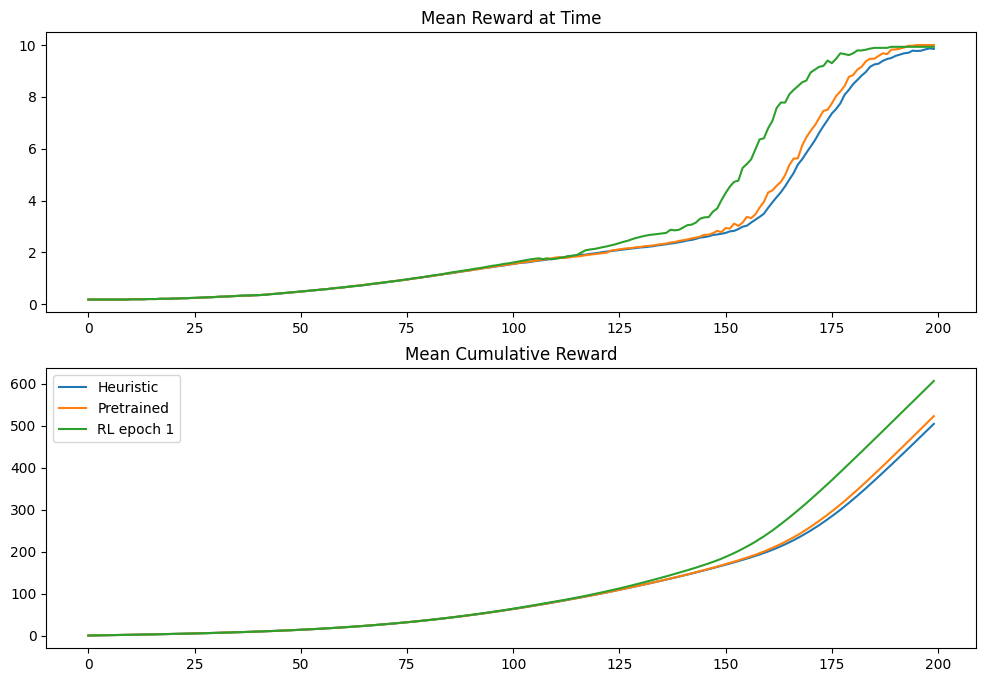


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 5.21e-055
> Trained the world model on the new data
Epoch [90/100], Loss: 5.386e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 0.0001413554127793759               
Replicate simulation 200/200

RL epoch 2 (rep. 6)
Final Reward: 604.0(+-79.55), C: 0.5% L: 98.0%, Lt: 158.28(+-9.43), Fuel: 22.0(+-1.03)



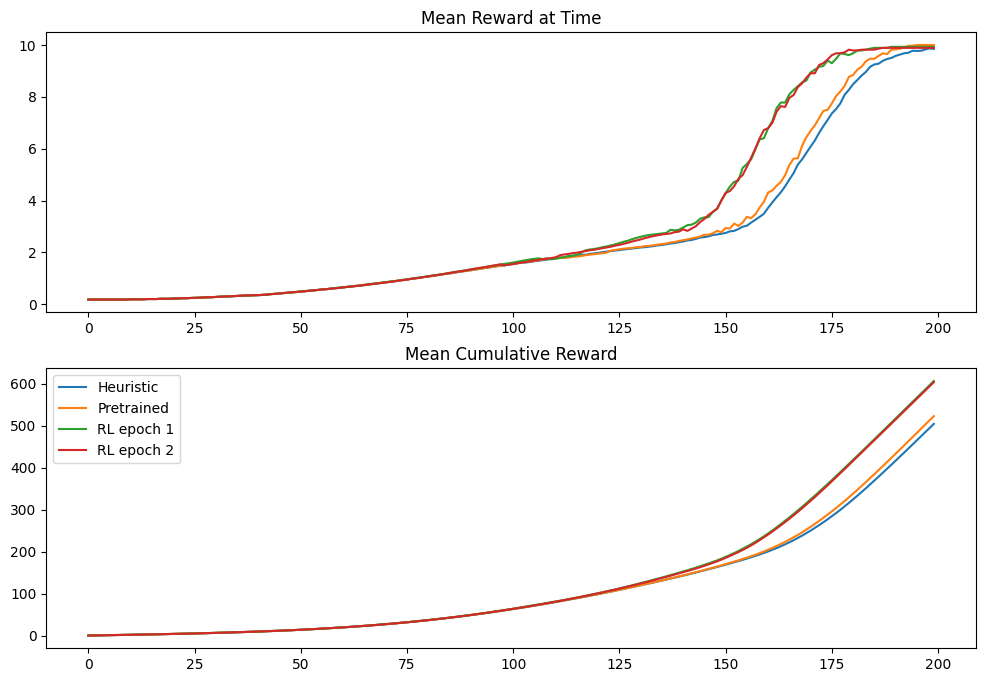


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 5.319e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.341e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 135.527099609375                    
Replicate simulation 200/200

RL epoch 3 (rep. 6)
Final Reward: 608.14(+-81.37), C: 0.0% L: 99.0%, Lt: 158.48(+-10.42), Fuel: 21.27(+-0.84)



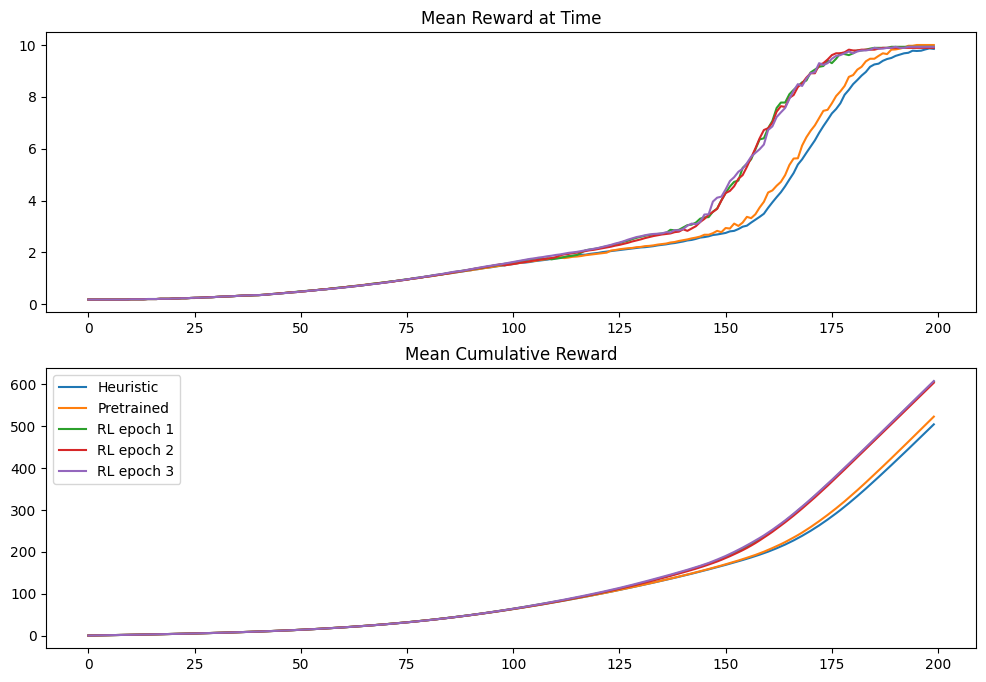


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.918e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.303e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 32.46514892578125                   
Replicate simulation 200/200

RL epoch 4 (rep. 6)
Final Reward: 604.06(+-82.81), C: 0.5% L: 98.0%, Lt: 158.9(+-9.91), Fuel: 21.44(+-1.0)



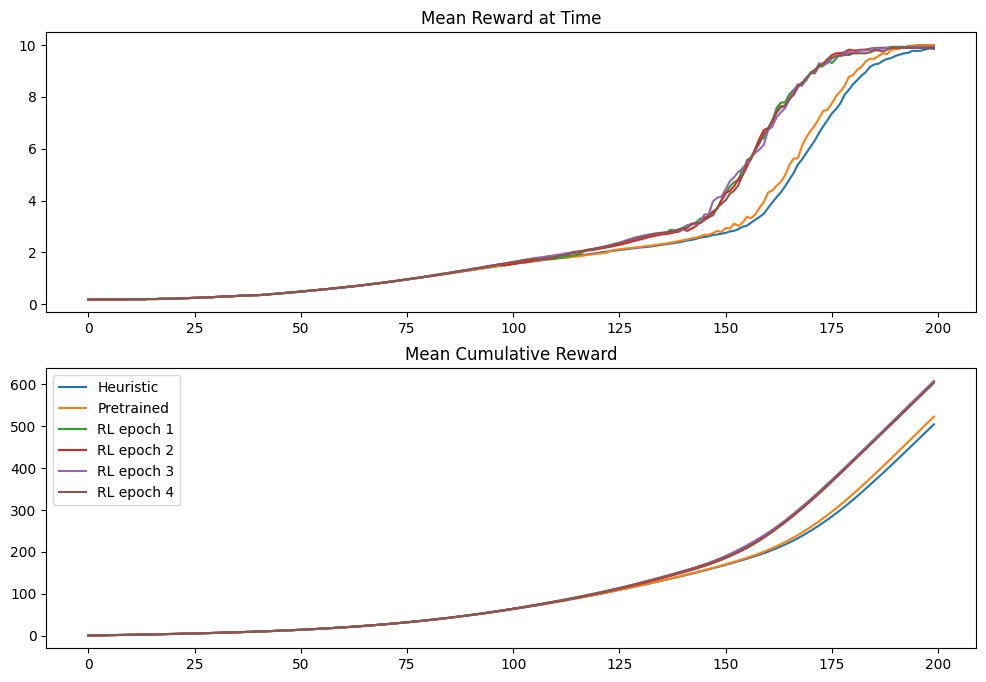


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.47e-055
> Trained the world model on the new data
Epoch [90/100], Loss: 5.184e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 111.95263671875                     
Replicate simulation 200/200

RL epoch 5 (rep. 6)
Final Reward: 609.76(+-84.64), C: 0.5% L: 98.0%, Lt: 158.1(+-10.32), Fuel: 21.34(+-1.01)



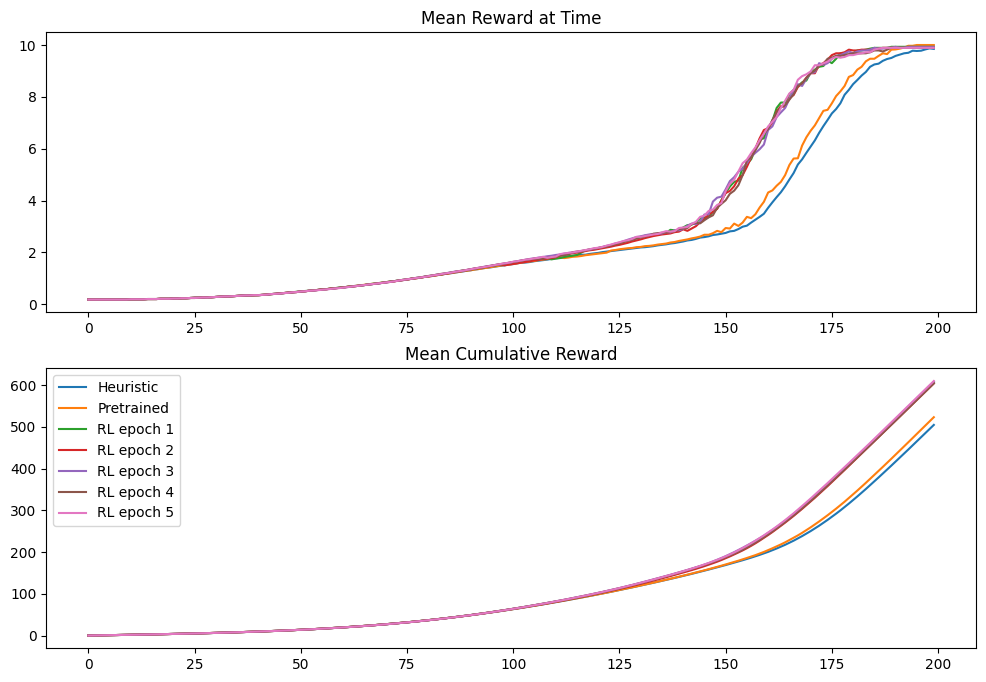

> Training complete for replicate 6. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      6   Heuristic    504.62      0.2    97.9             170.92   
1      6  Pretrained    523.08      0.5    99.5             169.11   
2      6  RL epoch 1    606.78      1.0    98.0             158.64   
3      6  RL epoch 2    604.00      0.5    98.0             158.28   
4      6  RL epoch 3    608.14      0.0    99.0             158.48   
5      6  RL epoch 4    604.06      0.5    98.0             158.90   
6      6  RL epoch 5    609.76      0.5    98.0             158.10   

   mean_fuel_consumption  
0                  24.59  
1                  24.36  
2                  21.41  
3                  22.00  
4                  21.27  
5                  21.44  
6                  21.34  

 -------------- Replicate 8/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

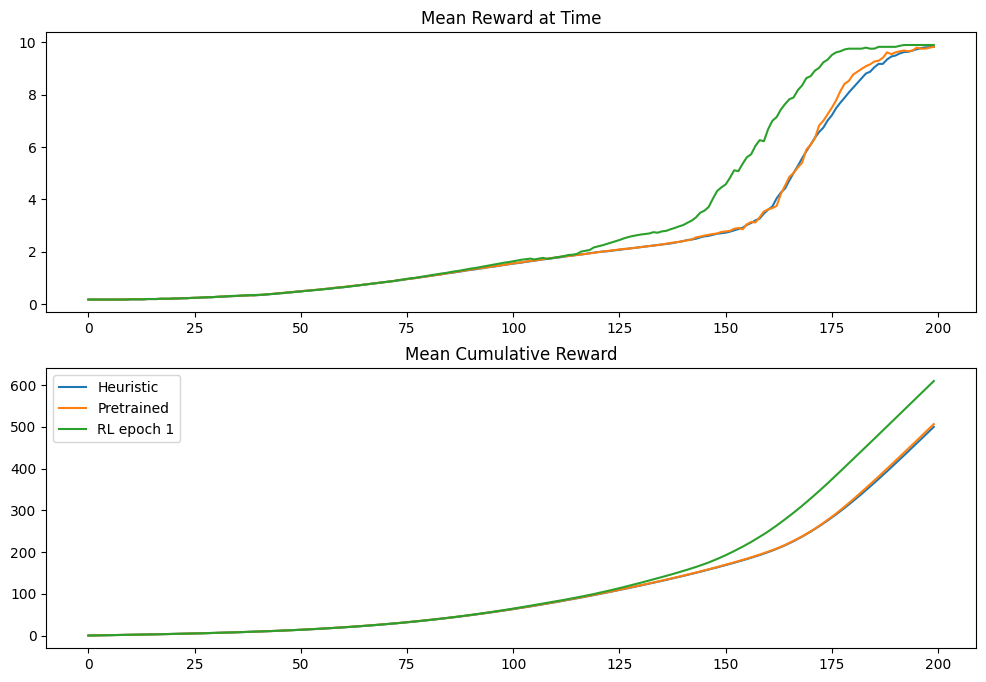


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 5.867e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.5e-0505
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 218.1820526123047                   
Replicate simulation 200/200

RL epoch 2 (rep. 7)
Final Reward: 621.52(+-101.76), C: 1.0% L: 95.5%, Lt: 156.76(+-11.33), Fuel: 19.38(+-0.86)



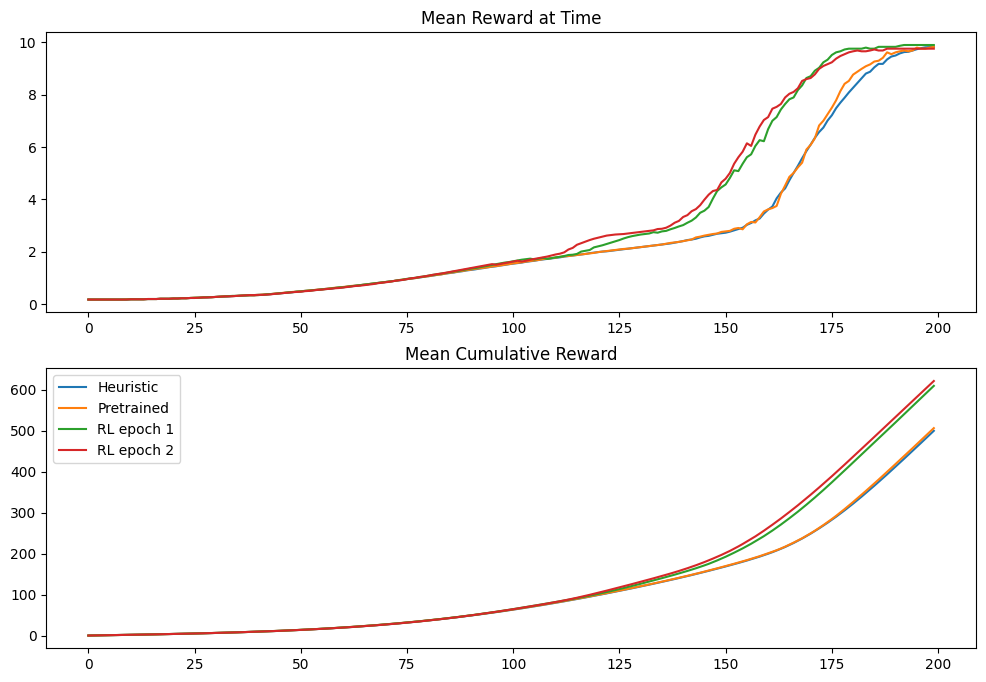


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 5.828e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.572e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 0.0002862210385501385               
Replicate simulation 200/200

RL epoch 3 (rep. 7)
Final Reward: 597.74(+-84.23), C: 0.5% L: 97.5%, Lt: 159.48(+-9.88), Fuel: 21.26(+-0.76)



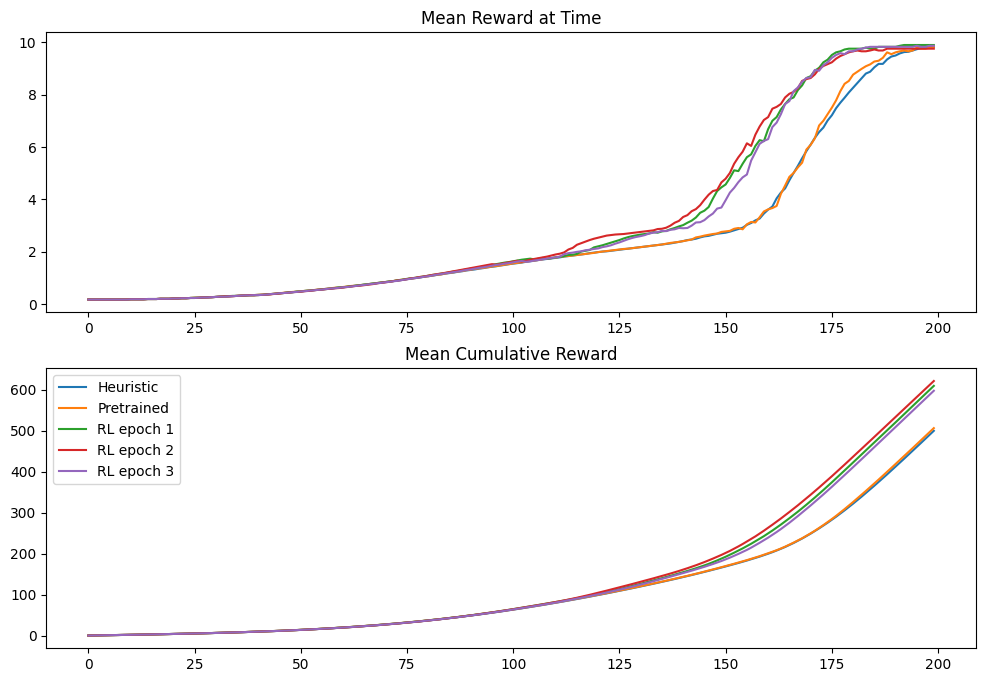


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.457e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 5.151e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 53.9652214050293                    
Replicate simulation 200/200

RL epoch 4 (rep. 7)
Final Reward: 584.68(+-74.89), C: 0.5% L: 98.5%, Lt: 161.29(+-9.34), Fuel: 22.3(+-0.81)



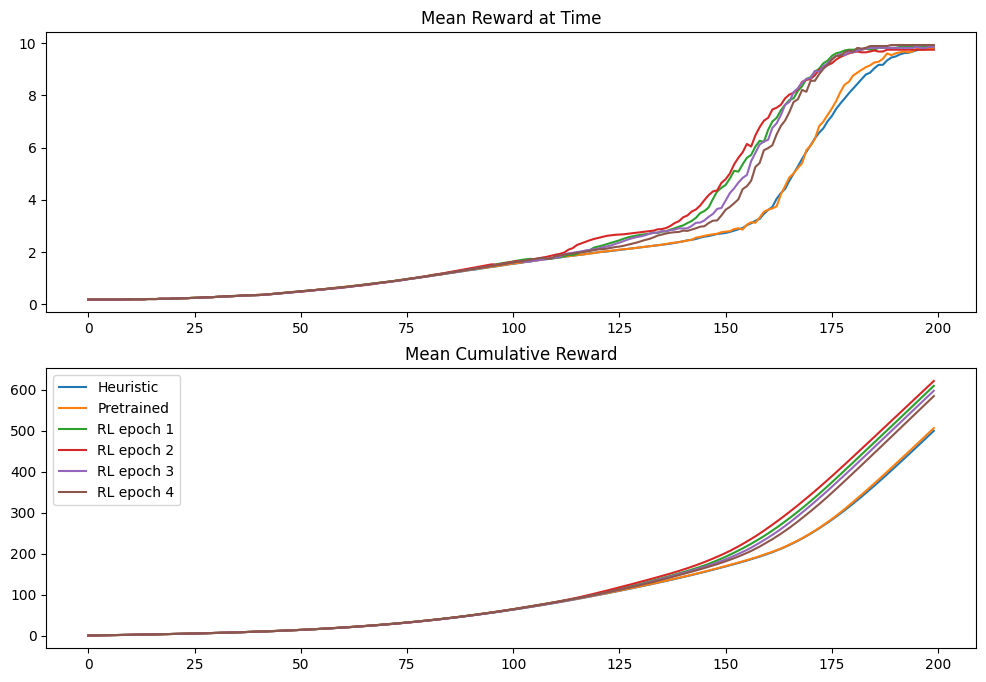


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.289e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.951e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 169.20254516601562                  
Replicate simulation 200/200

RL epoch 5 (rep. 7)
Final Reward: 581.01(+-72.33), C: 0.0% L: 99.5%, Lt: 161.93(+-9.5), Fuel: 22.27(+-0.89)



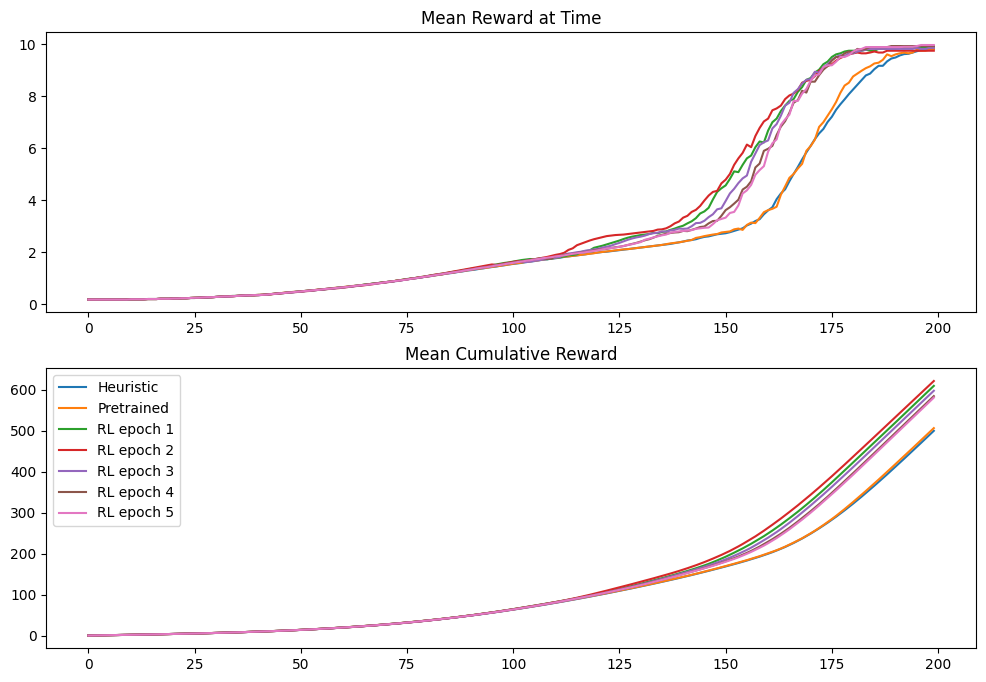

> Training complete for replicate 7. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      7   Heuristic    499.97      0.0    97.7             171.51   
1      7  Pretrained    506.51      0.0    97.5             170.65   
2      7  RL epoch 1    609.66      1.0    98.0             158.35   
3      7  RL epoch 2    621.52      1.0    95.5             156.76   
4      7  RL epoch 3    597.74      0.5    97.5             159.48   
5      7  RL epoch 4    584.68      0.5    98.5             161.29   
6      7  RL epoch 5    581.01      0.0    99.5             161.93   

   mean_fuel_consumption  
0                  24.64  
1                  24.68  
2                  20.89  
3                  19.38  
4                  21.26  
5                  22.30  
6                  22.27  

 -------------- Replicate 9/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training data

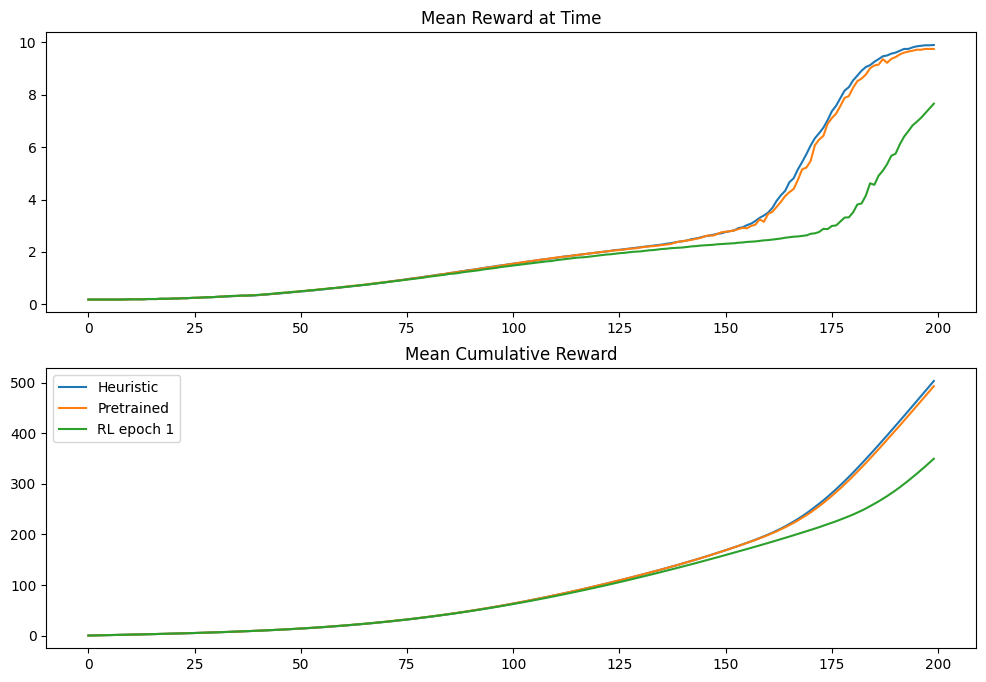


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.019e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.734e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 58.90827941894531                   
Replicate simulation 200/200

RL epoch 2 (rep. 8)
Final Reward: 335.94(+-62.98), C: 0.0% L: 65.5%, Lt: 188.67(+-7.53), Fuel: 29.15(+-1.88)



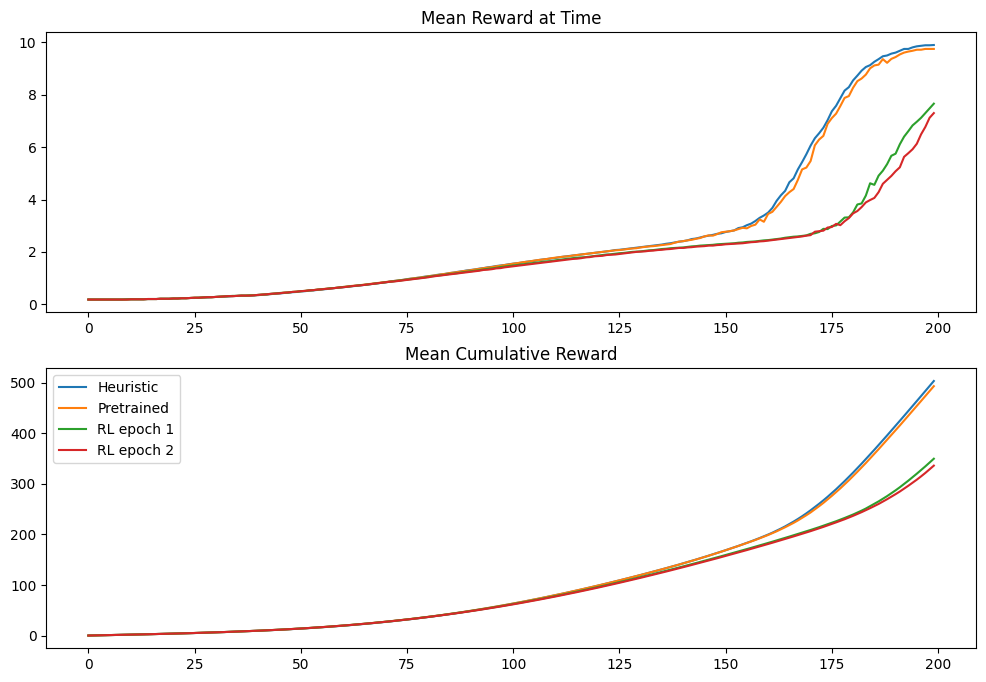


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.072e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.56e-055
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 11.386250495910645                  
Replicate simulation 200/200

RL epoch 3 (rep. 8)
Final Reward: 308.25(+-48.21), C: 0.0% L: 37.0%, Lt: 190.46(+-6.22), Fuel: 30.96(+-2.43)



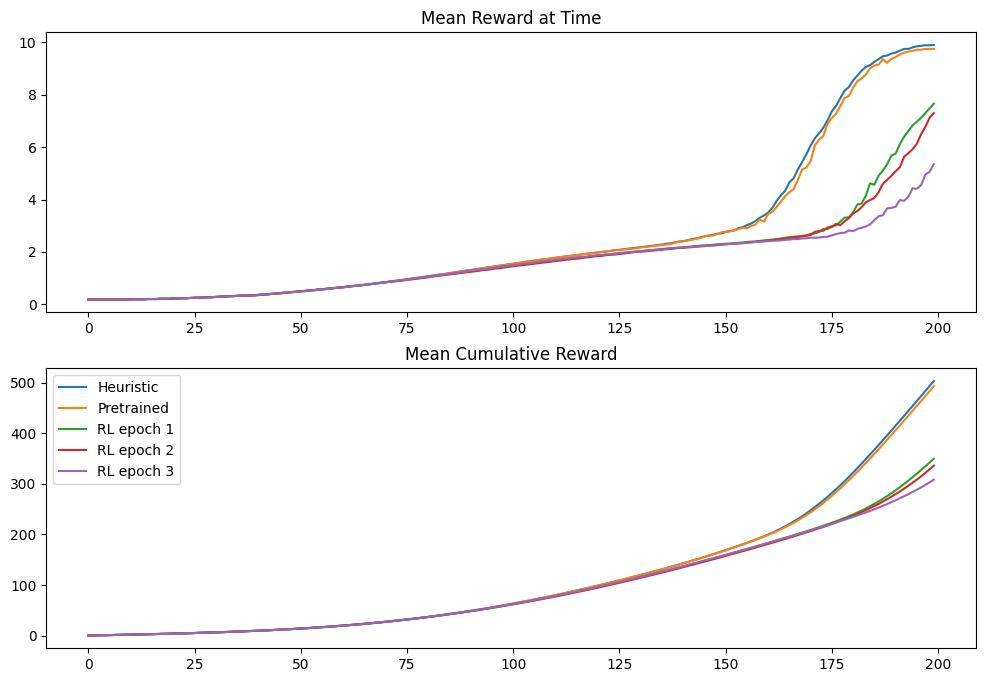


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.923e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.46e-055
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 102.24579620361328                  
Replicate simulation 200/200

RL epoch 4 (rep. 8)
Final Reward: 318.21(+-57.57), C: 0.0% L: 46.5%, Lt: 189.13(+-6.97), Fuel: 30.03(+-2.18)



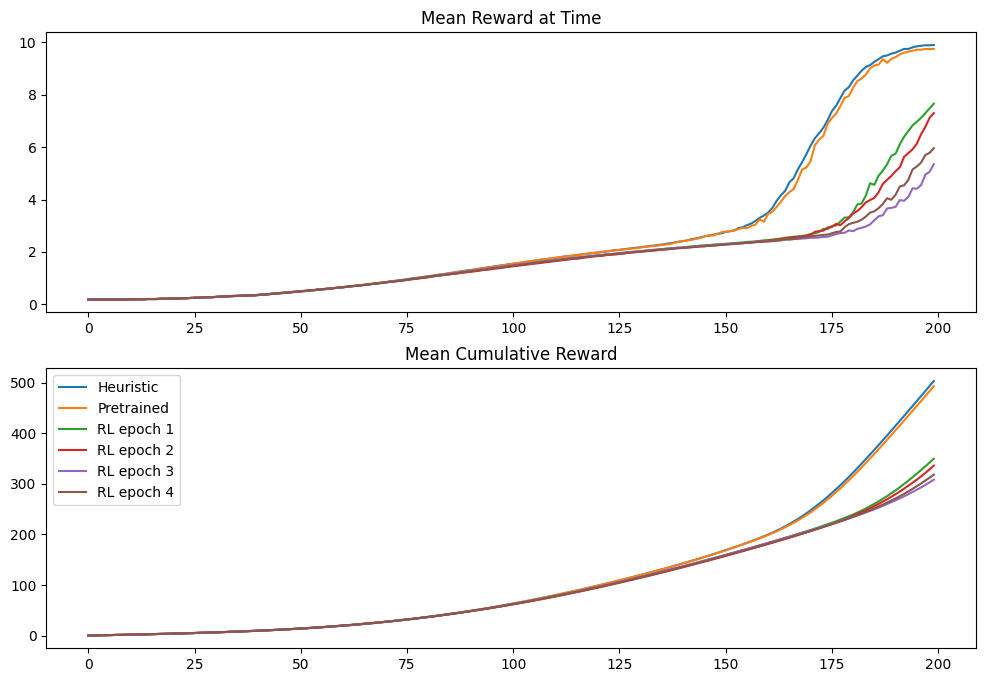


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.787e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.398e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 41.90160369873047                   
Replicate simulation 200/200

RL epoch 5 (rep. 8)
Final Reward: 292.77(+-42.7), C: 0.0% L: 26.0%, Lt: 190.87(+-6.27), Fuel: 31.36(+-2.44)



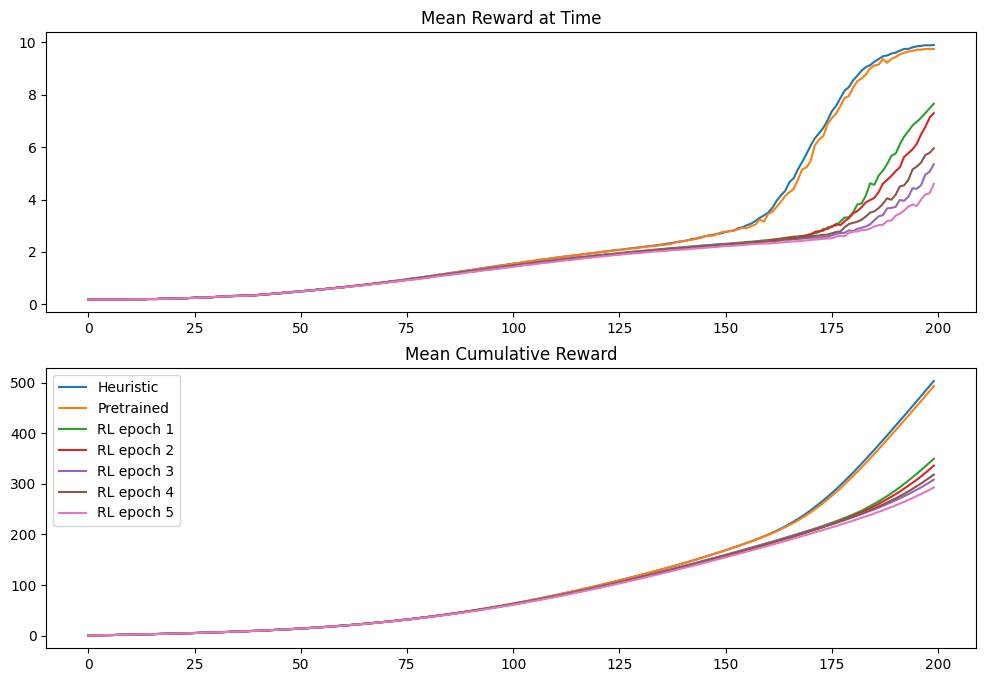

> Training complete for replicate 8. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      8   Heuristic    503.20      0.0    98.8             171.39   
1      8  Pretrained    492.98      0.0    97.0             172.23   
2      8  RL epoch 1    349.62      0.0    68.0             186.65   
3      8  RL epoch 2    335.94      0.0    65.5             188.67   
4      8  RL epoch 3    308.25      0.0    37.0             190.46   
5      8  RL epoch 4    318.21      0.0    46.5             189.13   
6      8  RL epoch 5    292.77      0.0    26.0             190.87   

   mean_fuel_consumption  
0                  24.64  
1                  25.06  
2                  29.01  
3                  29.15  
4                  30.96  
5                  30.03  
6                  31.36  

 -------------- Replicate 10/10 --------------
> Initialized the policy model and associated wrapper for evaluation.
Replicate simulation 1000/1000
> Generated pre-training dat

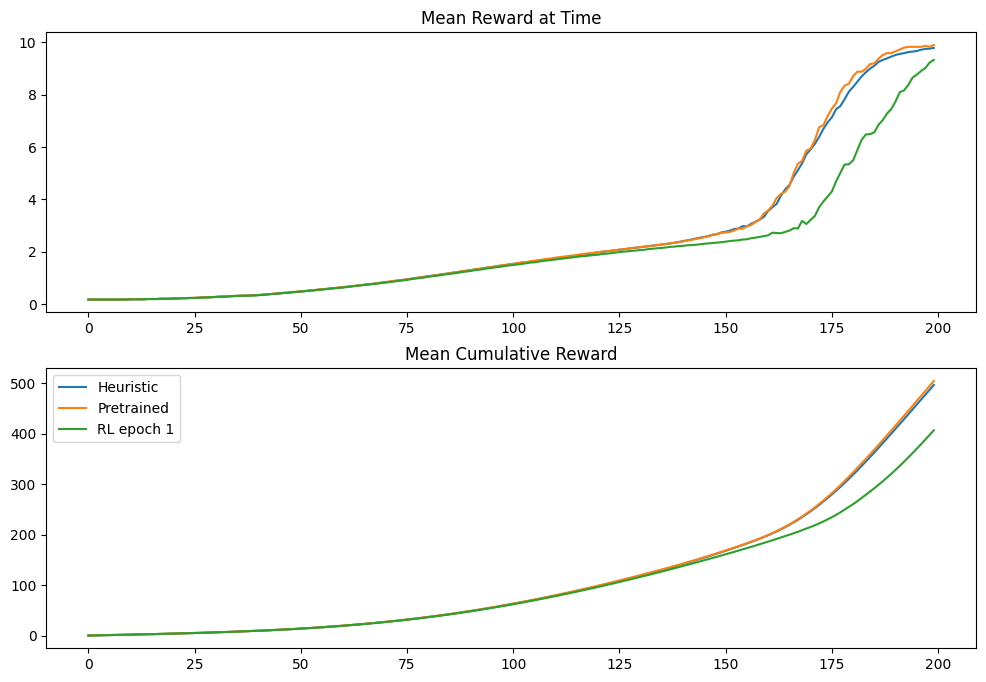


>> RL Iteration 2/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.239e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.947e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 83.2704086303711                    
Replicate simulation 200/200

RL epoch 2 (rep. 9)
Final Reward: 287.12(+-25.36), C: 0.0% L: 20.0%, Lt: 194.15(+-4.09), Fuel: 31.97(+-1.56)



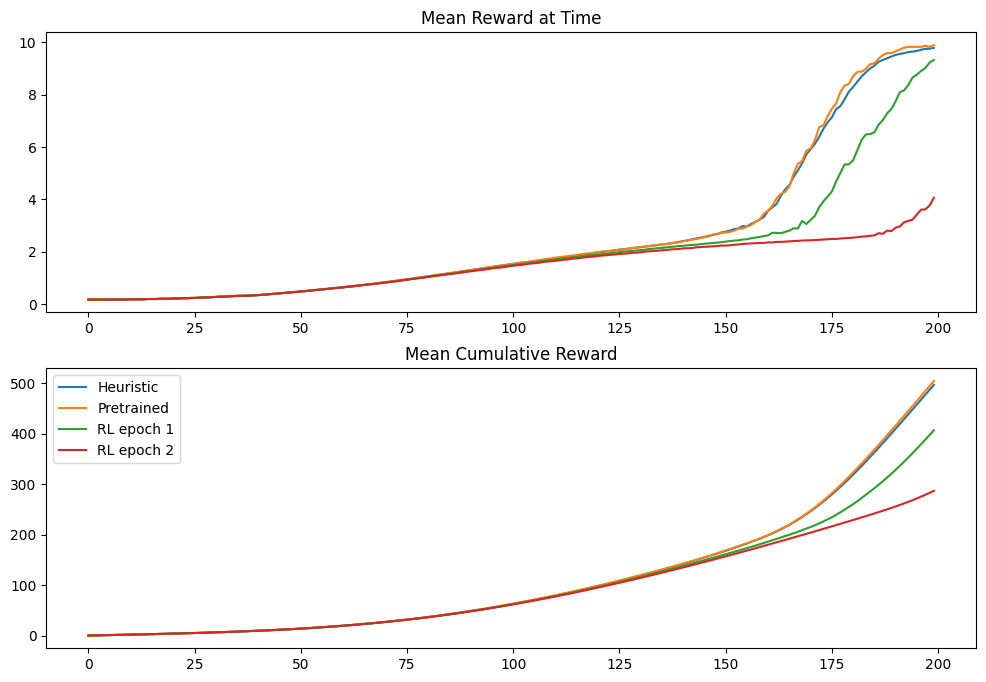


>> RL Iteration 3/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.171e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.78e-055
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 13.951469421386719                  
Replicate simulation 200/200

RL epoch 3 (rep. 9)
Final Reward: 306.28(+-41.54), C: 0.0% L: 39.5%, Lt: 191.61(+-5.66), Fuel: 30.84(+-2.04)



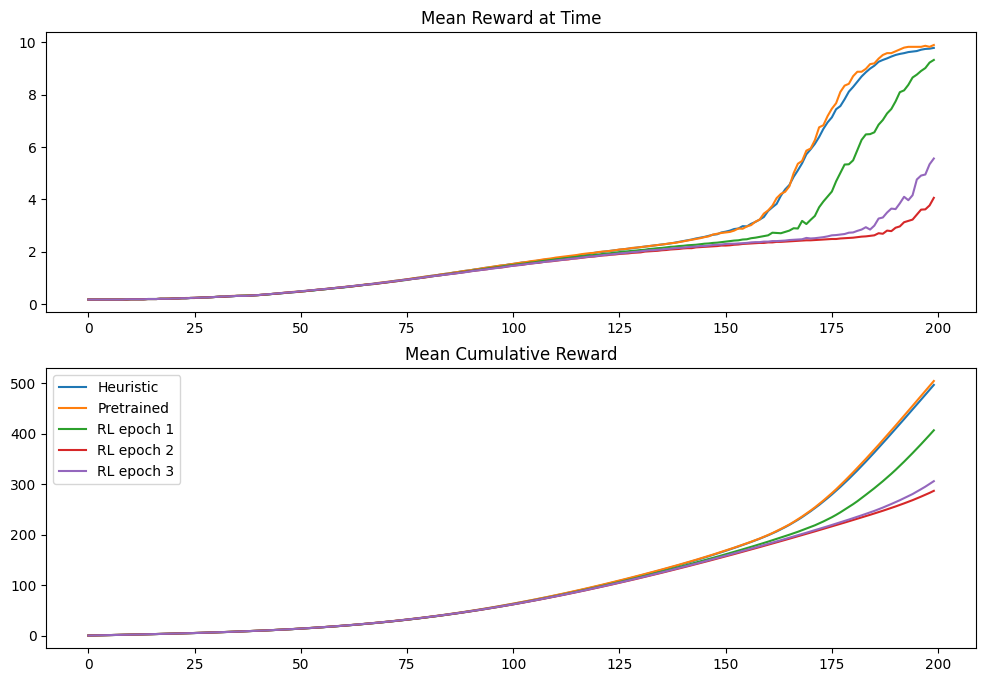


>> RL Iteration 4/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 3.969e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.616e-05
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 3.0390920639038086                   
Replicate simulation 200/200

RL epoch 4 (rep. 9)
Final Reward: 317.65(+-46.91), C: 0.5% L: 57.0%, Lt: 191.06(+-4.98), Fuel: 30.21(+-1.57)



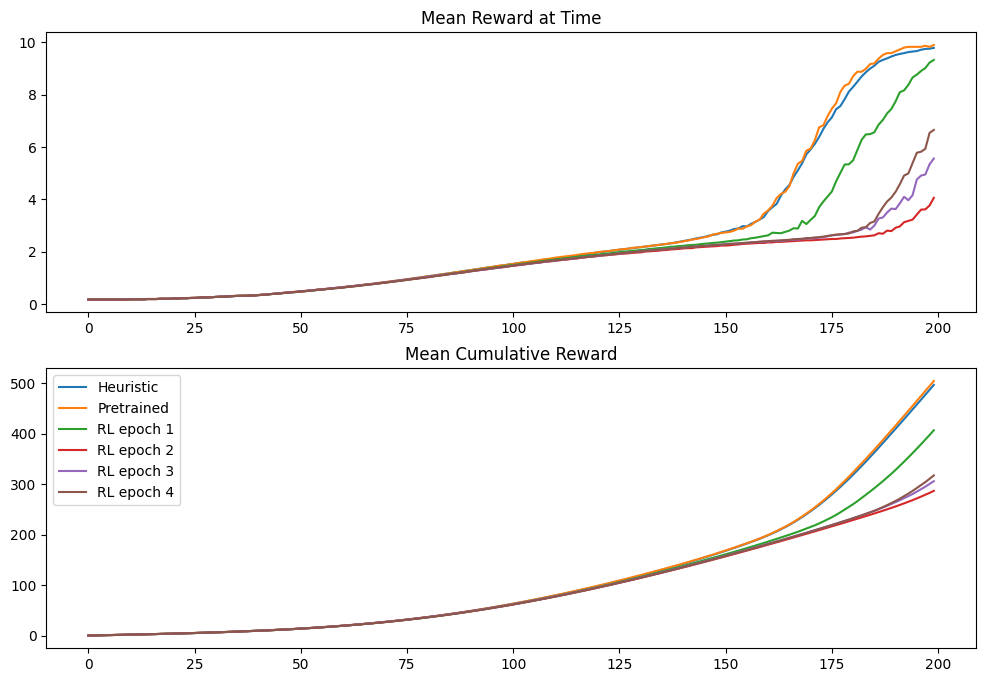


>> RL Iteration 5/5
Replicate simulation 200/200
Epoch [990/1000], Loss: 4.168e-05
> Trained the world model on the new data
Epoch [90/100], Loss: 4.5e-0505
> Shortly re-trained the world model on the full data
> Added 500 random states to the training set.
Step 500/500, Loss: 118.62623596191406                  
Replicate simulation 200/200

RL epoch 5 (rep. 9)
Final Reward: 333.51(+-59.15), C: 0.0% L: 61.5%, Lt: 188.97(+-6.6), Fuel: 29.73(+-1.76)



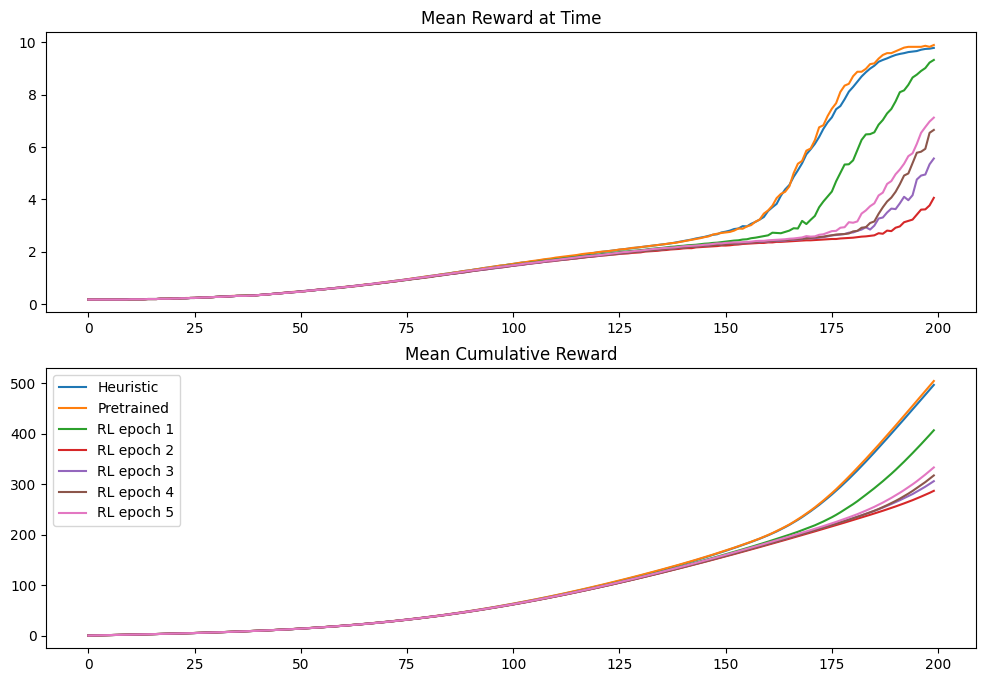

> Training complete for replicate 9. Results:
   rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0      9   Heuristic    497.16      0.2    96.7             171.60   
1      9  Pretrained    504.88      0.0    98.5             171.07   
2      9  RL epoch 1    407.16      0.0    91.5             181.99   
3      9  RL epoch 2    287.12      0.0    20.0             194.15   
4      9  RL epoch 3    306.28      0.0    39.5             191.61   
5      9  RL epoch 4    317.65      0.5    57.0             191.06   
6      9  RL epoch 5    333.51      0.0    61.5             188.97   

   mean_fuel_consumption  
0                  24.66  
1                  24.90  
2                  27.22  
3                  31.97  
4                  30.84  
5                  30.21  
6                  29.73  


 Final Results:
    rep_i result_name  c_reward  crashed  landed  mean_landing_time  \
0       0   Heuristic    500.99      0.1    98.4             171.59   
1       0  Pretra

In [28]:
final_results_list = []
REPLICATES = 10
for r in range(REPLICATES):
    print(f'\n -------------- Replicate {r+1}/{REPLICATES} --------------')
    
    results_list = []
    rewards_over_time_list = []

    # Reset the true environment
    env = LunarLander(render_mode='rgb_array')
    _, _ = env.reset()

    """PRETRAINING OF THE POLICY"""

    # Initialize the policy model
    policy_model = NNPolicy()
    policy_model.to(compute_device)

    def nn_policy_wrapper(state):
        state_tensor = torch.tensor(state[0:6], device=compute_device, dtype=torch.float32).unsqueeze(0)
        action_onehot = policy_model.act_eval(state_tensor).detach().cpu().numpy()
        action_index = np.argmax(action_onehot)
        return action_index
    print('> Initialized the policy model and associated wrapper for evaluation.')

    # Generate pre-training data
    pretrain_data_dict = simulate_with_policy(env, 1000, heuristic_policy)
    print('> Generated pre-training data')
    results_list = update_results_list(results_list, 'Heuristic', r, pretrain_data_dict)
    rewards_over_time_list = update_rewards_over_time_list(rewards_over_time_list, 'Heuristic', pretrain_data_dict)
    
    # Pre-train the policy to imitate the heuristic
    pretrain_policy(
        policy_model, 
        pretrain_data_dict, 
        epochs = 10,
        lr = 0.001
        )
    print('> Pre-trained the policy model to imitate the heuristic controller.')

    # Evaluate the pre-trained policy
    pretrain_eval_data_dict = simulate_with_policy(env, 200, nn_policy_wrapper)
    results_list = update_results_list(results_list, 'Pretrained', r, pretrain_eval_data_dict)
    rewards_over_time_list = update_rewards_over_time_list(rewards_over_time_list, 'Pretrained', pretrain_eval_data_dict)

    """PRETRAINING OF THE WORLD MODEL"""

    # Initialize the dataset for pre-training the world model
    pretrain_data_dict = simulate_with_policy(env, 1000, nn_policy_wrapper)
    dataset = DataSet(pretrain_data_dict)
    _, data_loader = dataset.get_TE_dataloaders(var_from='INPUT', var_to='STATE')
    print('> Initialized the dataset for pre-training the world model.')

    # Initialize the world model
    _, world_model = init_agms_from_loaders(_, data_loader, hidden_size=256, num_layers=3, dyn_model_type='MLPDiff', obs_model_type='regression')
    world_model.to(compute_device)
    print('> Initialized the world model.')

    # Pre-train the world model
    world_model, losses = _train_agm(
        world_model, data_loader, 
        batch_size=int(100), 
        epochs = 200, 
        learning_rate=0.001, 
        optimize='adam', 
        lr_decay_gamma=0.99, 
        lr_decay_step=20
        )
    print()
    print('> Trained the initial world model.')


    """AGM-REINFORCE TRAINING"""

    training_data_dict_list = []
    total_policy_data_dict = {'STATE':[], 'INPUT':[], 'REWARD':[]}
    worldmodel_data_dict = pretrain_data_dict # copy over the pretraining data

    SIM_PER_ITER = 200
    ITERS = 5

    for i in range(ITERS):
        print(f'\n>> RL Iteration {i+1}/{ITERS}')

        # Gather data for the current policy
        data_dict = simulate_with_policy(env, SIM_PER_ITER, nn_policy_wrapper)
        training_data_dict_list.append(data_dict)
        dataset_new = DataSet(data_dict)

        # Add the new trajectories to the policy and world model training data
        for j in range(SIM_PER_ITER): 
            total_policy_data_dict['STATE'].append(data_dict['STATE'][j])
            total_policy_data_dict['INPUT'].append(data_dict['INPUT'][j])
            total_policy_data_dict['REWARD'].append(data_dict['REWARD'][j])

            worldmodel_data_dict['STATE'].append(data_dict['STATE'][j])
            worldmodel_data_dict['INPUT'].append(data_dict['INPUT'][j])
            worldmodel_data_dict['REWARD'].append(data_dict['REWARD'][j])

        # Train the world model on the new data
        _, data_loader = dataset_new.get_TE_dataloaders(var_from='INPUT', var_to='STATE')
        world_model, losses = _train_agm(
            world_model, data_loader, 
            batch_size=100, 
            epochs = 1000, 
            learning_rate=0.00002, 
            optimize='adam', 
            lr_decay_gamma=0.99, 
            lr_decay_step=20
            )
        print()
        print(f'> Trained the world model on the new data')

        # Remind the world model of the old data
        dataset_full = DataSet(worldmodel_data_dict)
        _, data_loader = dataset_full.get_TE_dataloaders(var_from='INPUT', var_to='STATE')
        world_model, losses = _train_agm(
            world_model, data_loader, 
            batch_size=100, 
            epochs = 100, 
            learning_rate=0.00001, 
            optimize='adam', 
            lr_decay_gamma=0.95, 
            lr_decay_step=10
            )
        print()
        print(f'> Shortly re-trained the world model on the full data')

        # Select a sample set of states on which to train the policy
        state_list = []

        # Select a sample set of challenging crash states from the most recent data on which to train the policy
        crash_challenge_state_list = crash_challenge_state_selector(total_policy_data_dict, max_t_sample=200, sample_size=10)
        state_list.extend(crash_challenge_state_list)
        
        # Select a sample set of random states on which to train the policy
        random_state_list = state_selector(total_policy_data_dict, max_t_sample=200, sample_size=500)
        state_list.extend(random_state_list)
        
        print(f'> Added {len(random_state_list)} random states to the training set.')
         

        # Train the policy
        RL_train_policy(
            policy_model,
            world_model,
            state_list,
            horizon=25,
            gamma=0.99,
            lr = 1e-6
            )

        # Test the policy
        test_data_dict = simulate_with_policy(env, 200, nn_policy_wrapper)
        results_list = update_results_list(results_list, f'RL epoch {i+1}', r, test_data_dict)
        rewards_over_time_list = update_rewards_over_time_list(rewards_over_time_list, f'RL epoch {i+1}', test_data_dict)
        reward_over_time_plotting(rewards_over_time_list)

    # Print the final feedback from the r-th replicate
    print(f'> Training complete for replicate {r}. Results:')
    df = pd.DataFrame.from_records(results_list)
    print(df)
    df.to_csv(f'results_{r}.csv')

    # Append the results from the replicate to the final results list
    for result in results_list:
        final_results_list.append(result)

print('\n\n Final Results:')
df = pd.DataFrame.from_records(final_results_list)
print(df)
df.to_csv('results_total.csv')